# Análisis exploratorio de los datos del COVID-19

In [102]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import urllib
import datetime
from scipy.ndimage.filters import gaussian_filter1d

# Importación y tratamiento de los datos

## Leer datos desde OpenData

In [103]:
url = f'https://opendata.ecdc.europa.eu/covid19/casedistribution/json/'

response = urllib.request.urlopen(url)

json_data = json.loads(response.read())

tam = len(json_data['records'])

if tam > 1:
    print(f"Información descargada con {tam} registros JSON")
else:
    print(r'La información no se ha podido descargar correctamente' )

Información descargada con 9310 registros JSON


## Guardarlos en fichero JSON

In [104]:
if tam > 1:
    with open('opendata_covid19.json', 'w') as json_file:
        json.dump(json_data['records'], json_file)
    print(f"Fichero guardado con {tam} registros JSON")
else:
     print(r'El fichero no se ha podido descargar correctamente' )

Fichero guardado con 9310 registros JSON


## Cargar el fichero JSON a un objeto Pandas DataFrame

In [105]:
data = pd.read_json('opendata_covid19.json')

## Tratamiento de los datos y creación de nuevas variables

In [106]:
data.dateRep = pd.to_datetime(data.dateRep, format='%d/%m/%Y')
#data.day = data.day.astype(int)
#data.month = data.month.astype(int)
#data.year = data.year.astype(int)
data.cases = data.cases.astype(int)
data.deaths = data.deaths.astype(int)
data.countriesAndTerritories = data.countriesAndTerritories.astype(str)
data.geoId = data.geoId.astype(str)
data.countryterritoryCode = data.countryterritoryCode.astype(str)
data.popData2018  = pd.to_numeric(data.popData2018, errors='coerce')

#Resto un dia a los datos porque la fuente de los datos con desfase de un día.
#https://opendata.ecdc.europa.eu/covid19/casedistribution/json/
data.dateRep = data.dateRep - datetime.timedelta(days=1)
data.day = data.dateRep.dt.day.astype(int)
data.month = data.dateRep.dt.month.astype(int)
data.year = data.dateRep.dt.year.astype(int)

#Ordenamos los datos por pais y dia
data = data.sort_values(by=['countriesAndTerritories', 'dateRep'], ascending=True)

#Añadimos nuevas columnas con los datos acumulados
data['casesacum'] = data.groupby('countriesAndTerritories')['cases'].transform(pd.Series.cumsum)
data['deathsacum'] = data.groupby('countriesAndTerritories')['deaths'].transform(pd.Series.cumsum)

data['%cases'] = data['casesacum']/data['popData2018']*100

data['4_days'] = data.groupby([data['countriesAndTerritories']])['casesacum'].shift(4)
data['ratio4'] = data['casesacum']/data['4_days']


#Añadimos una nueva columna que empieza a contar el inicio del contagio en cada pais desde el día que se superan los 100 contagiados
day_0 = 0
number_cases_day_0 = 100

for index, row in data.iterrows():
    if row['casesacum'] >= number_cases_day_0:
        day_0+=1
    else:
        day_0=0
    
    data.loc[index, 'day_0'] = day_0

data.day_0 = data.day_0.astype(int)

In [107]:
data.sample(5)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2018,casesacum,deathsacum,%cases,4_days,ratio4,day_0
6974,2020-04-04,4,4,2020,244,8,Poland,PL,POL,37978548.0,3627,79,0.009550,2311.0,1.569450,22
6833,2020-03-23,23,3,2020,5,0,Paraguay,PY,PRY,6956071.0,27,1,0.000388,13.0,2.076923,0
2791,2020-03-18,18,3,2020,33,0,Estonia,EE,EST,1320884.0,258,0,0.019532,115.0,2.243478,5
1732,2020-04-02,2,4,2020,0,0,Central_African_Republic,CF,CAF,4666377.0,8,0,0.000171,6.0,1.333333,0
2348,2020-02-15,15,2,2020,0,0,Denmark,DK,DNK,5797446.0,0,0,0.000000,0.0,NaN,0


# Comparativa paises

## Casos totales acumulados COVID-19

In [108]:
acumuladosPais = data.groupby(['countriesAndTerritories','geoId','popData2018']).agg({'cases':'sum', 'deaths':'sum'}).reset_index()
acumuladosPais = acumuladosPais.sort_values(by=['cases'], ascending=False).head(20)
acumuladosPais.head(5)

,countriesAndTerritories,geoId,popData2018,cases,deaths
192,United_States_of_America,US,3.271674e+08,368196,10989
171,Spain,ES,4.672375e+07,135032,13055
93,Italy,IT,6.043128e+07,132547,16525
69,Germany,DE,8.292792e+07,99225,1607
40,China,CN,1.392730e+09,82698,3335


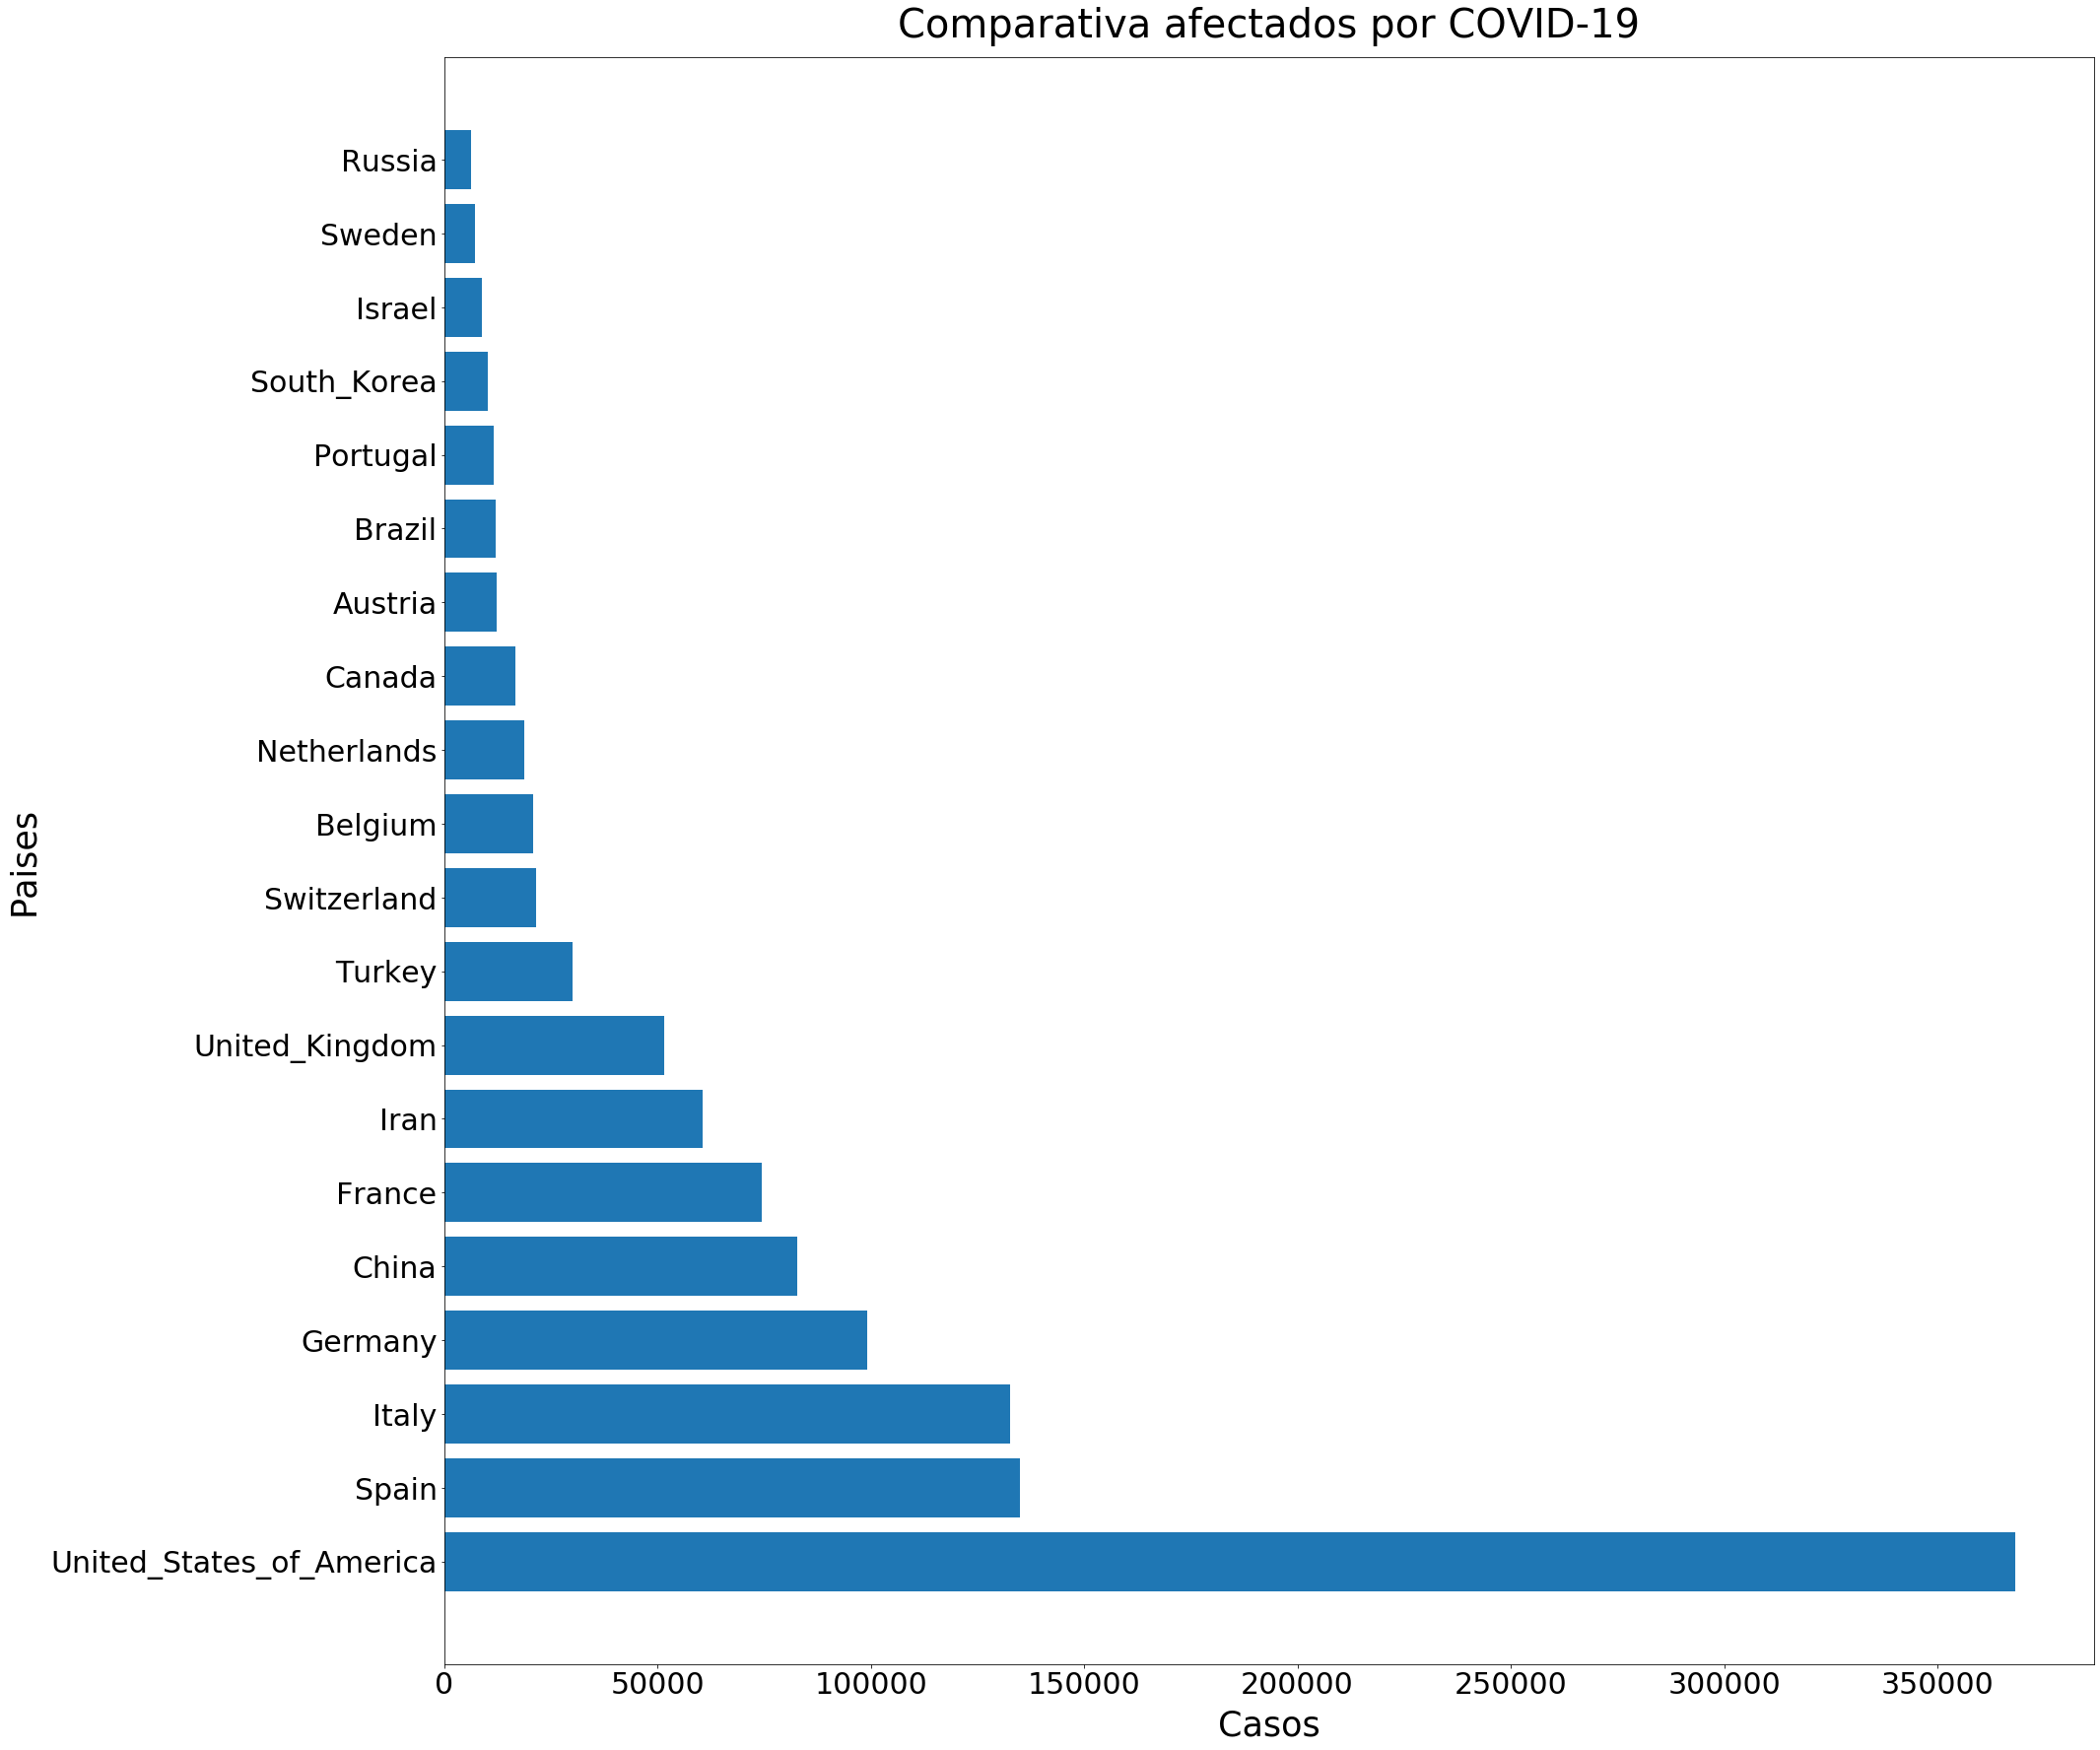

In [109]:
plt.subplots(figsize=(30,30))

plt.barh(acumuladosPais['countriesAndTerritories'], acumuladosPais['cases'])

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Casos", fontsize=35, labelpad=10)
plt.ylabel("Paises", fontsize=35, labelpad=10)
plt.title("Comparativa afectados por COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("ComparativaPaises.jpg", bbox_inches = "tight")

plt.show()

In [110]:
acumuladosPais['%cases'] = (acumuladosPais['cases']/acumuladosPais['popData2018'])*100
acumuladosPais = acumuladosPais.sort_values(by=['%cases'], ascending=False).head(20)
acumuladosPais.head(5)

,countriesAndTerritories,geoId,popData2018,cases,deaths,%cases
171,Spain,ES,46723749.0,135032,13055,0.289001
176,Switzerland,CH,8516543.0,21574,584,0.253319
93,Italy,IT,60431283.0,132547,16525,0.219335
17,Belgium,BE,11422068.0,20814,1632,0.182226
10,Austria,AT,8847037.0,12297,220,0.138996


## Porcentaje casos totales acumulados COVID-19

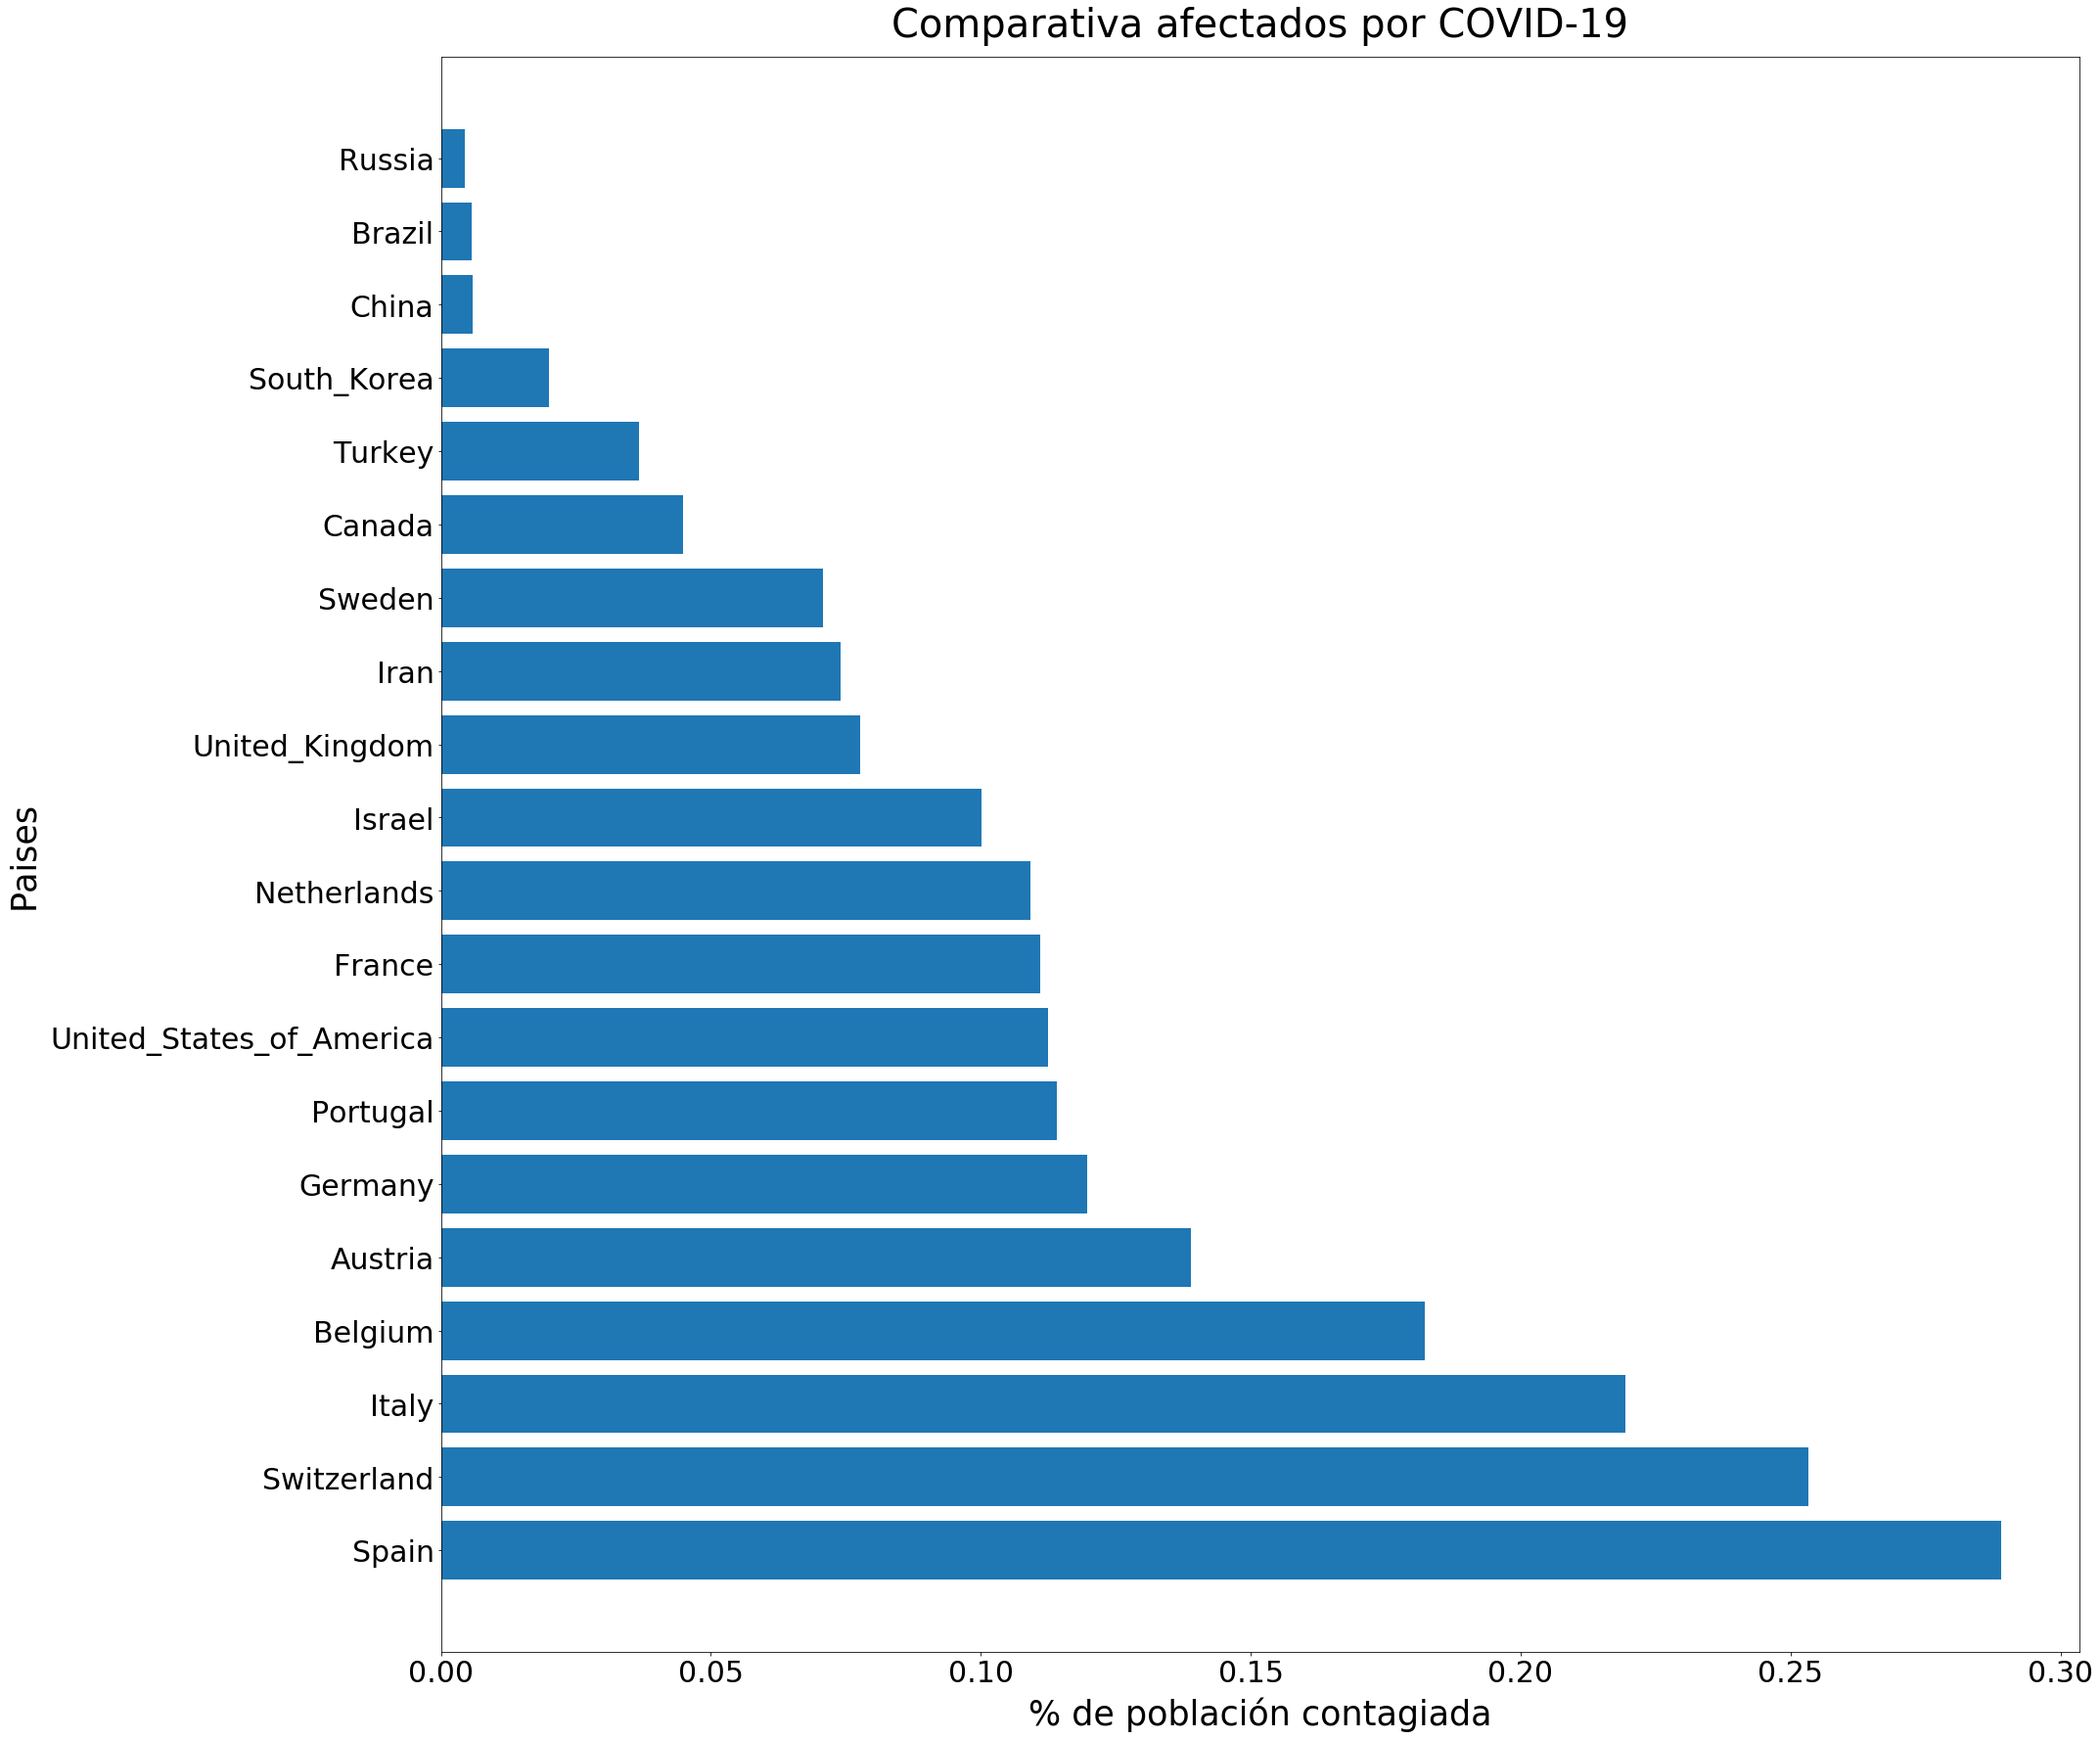

In [111]:
plt.subplots(figsize=(30,30))

plt.barh(acumuladosPais['countriesAndTerritories'], acumuladosPais['%cases'])

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("% de población contagiada", fontsize=35, labelpad=10)
plt.ylabel("Paises", fontsize=35, labelpad=10)
plt.title("Comparativa afectados por COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("ComparativaPaises%casos.jpg", bbox_inches = "tight")

plt.show()

## Comparativa paises casos diarios COVID-19

In [112]:
US = data[(data['countriesAndTerritories'] == 'United_States_of_America') & (data['dateRep'] > '15/01/2020')]
IT = data[(data['countriesAndTerritories'] == 'Italy') & (data['dateRep'] > '15/01/2020')]
ES = data[(data['countriesAndTerritories'] == 'Spain') & (data['dateRep'] > '15/01/2020')]
CN = data[(data['countriesAndTerritories'] == 'China') & (data['dateRep'] > '15/01/2020')]
DE = data[(data['countriesAndTerritories'] == 'Germany') & (data['dateRep'] > '15/01/2020')]
FR = data[(data['countriesAndTerritories'] == 'France') & (data['dateRep'] > '15/01/2020')]
IR = data[(data['countriesAndTerritories'] == 'Iran') & (data['dateRep'] > '15/01/2020')]
UK = data[(data['countriesAndTerritories'] == 'United_Kingdom') & (data['dateRep'] > '15/01/2020')]

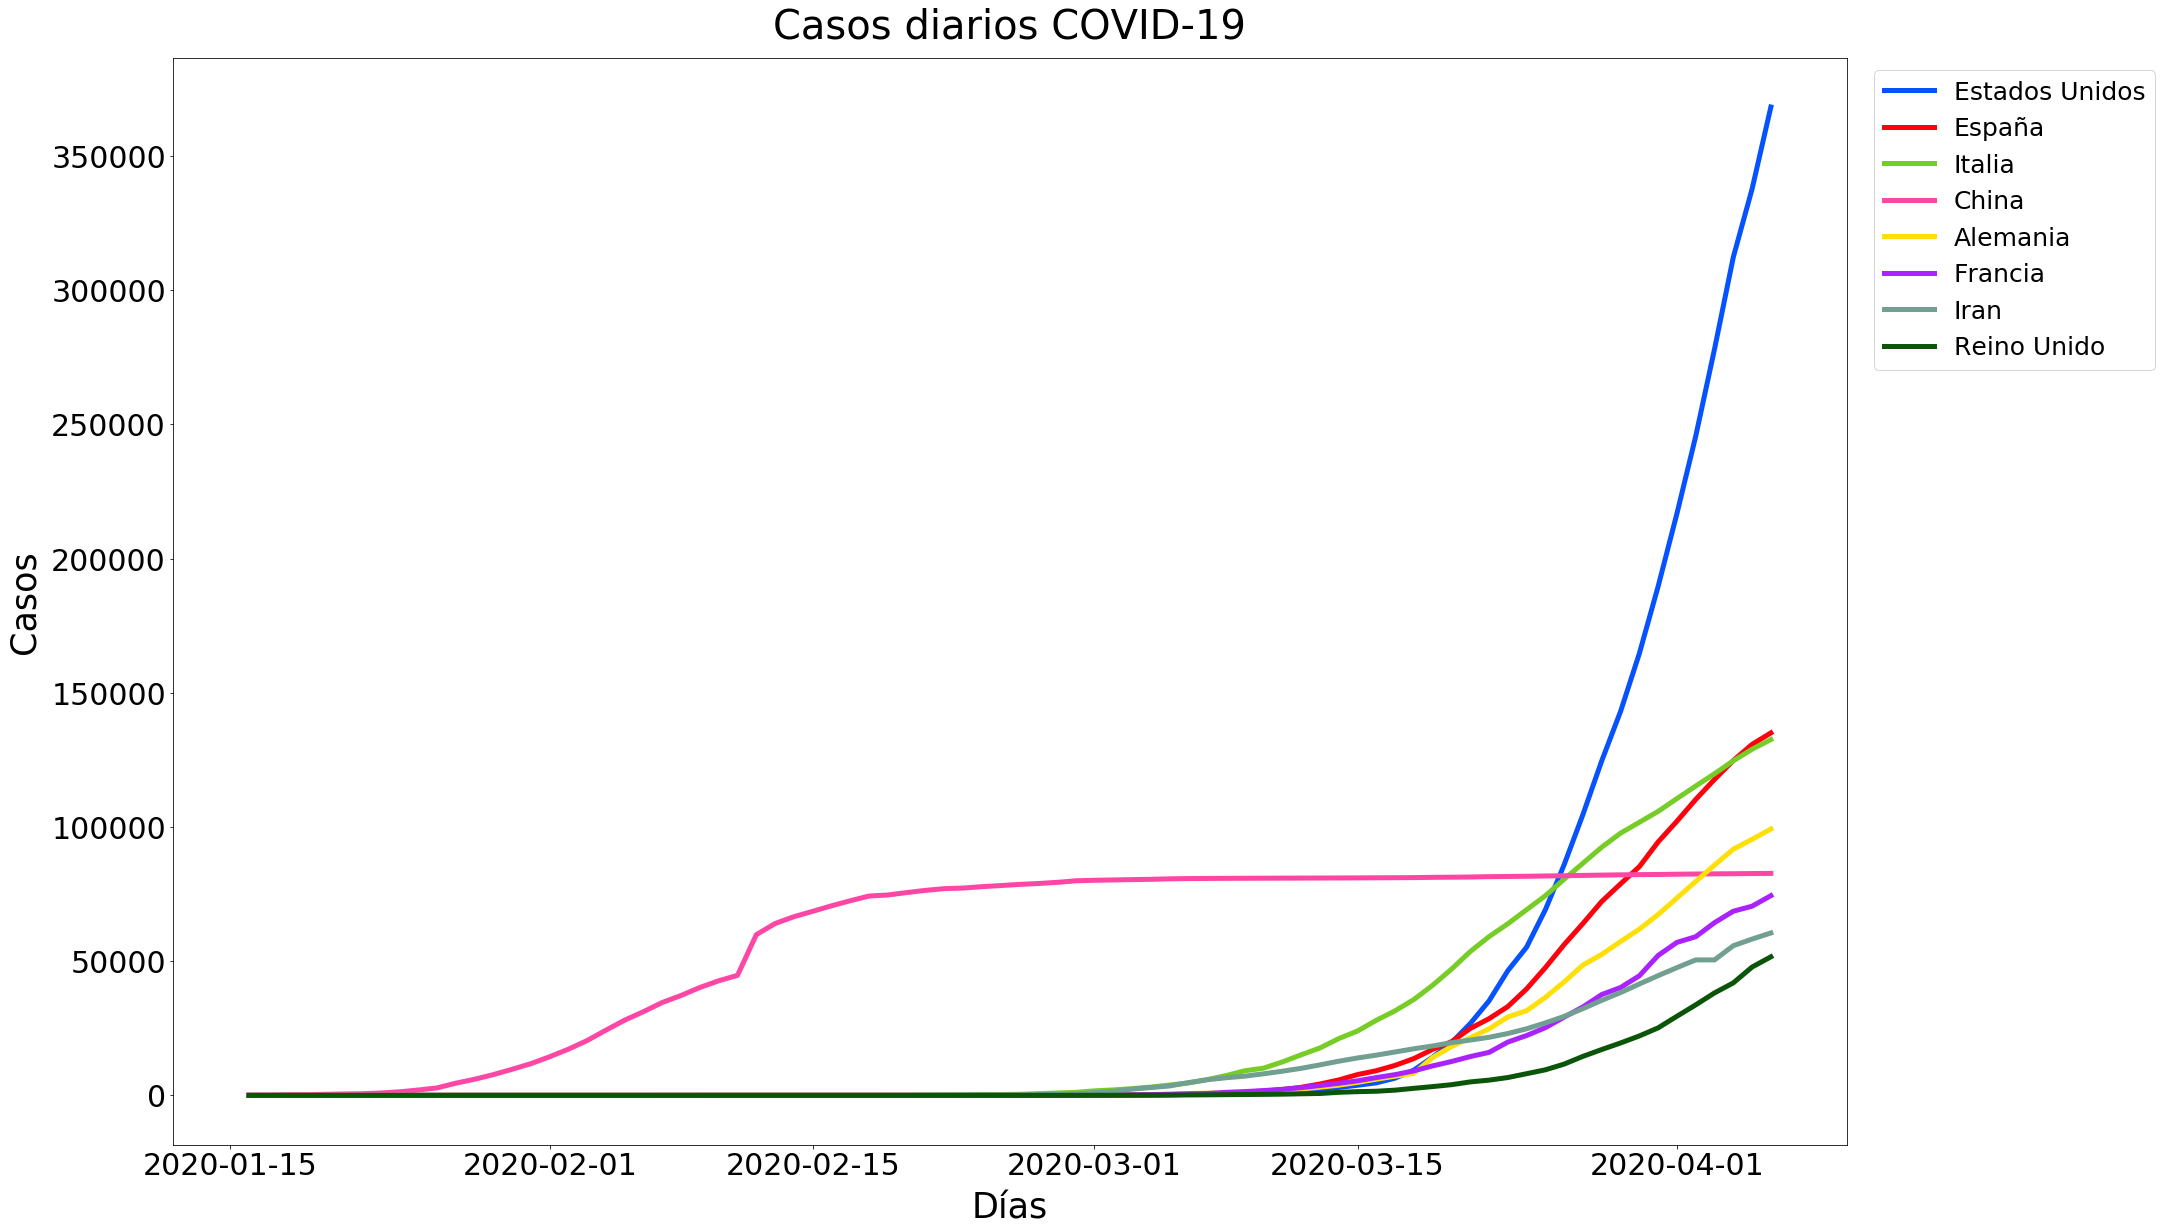

In [113]:
ax = plt.subplots(figsize=(30,20))

plt.plot(US['dateRep'], US['casesacum'], label = 'Estados Unidos', linewidth=5, color = 'xkcd:electric blue')
plt.plot(ES['dateRep'], ES['casesacum'], label = 'España', linewidth=5, color = 'xkcd:bright red')
plt.plot(IT['dateRep'], IT['casesacum'], label = 'Italia', linewidth=5, color = 'xkcd:apple green')
plt.plot(CN['dateRep'], CN['casesacum'], label = 'China', linewidth=5, color = 'xkcd:barbie pink') 
plt.plot(DE['dateRep'], DE['casesacum'], label = 'Alemania', linewidth=5, color = 'xkcd:dandelion') 
plt.plot(FR['dateRep'], FR['casesacum'], label = 'Francia', linewidth=5, color = 'xkcd:electric purple')
plt.plot(IR['dateRep'], IR['casesacum'], label = 'Iran', linewidth=5, color = 'xkcd:greyish teal')
plt.plot(UK['dateRep'], UK['casesacum'], label = 'Reino Unido', linewidth=5, color = 'xkcd:forest')
                
plt.legend(loc='upper left')

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')

plt.legend(prop = {'size':25}, loc = 'upper center', bbox_to_anchor=(1.1, 1))
    
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Casos", fontsize=35, labelpad=10)
plt.title("Casos diarios COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("CasosDiarios.jpg", bbox_inches = "tight")
plt.show()

## Comparativa paises casos diarios COVID-19 contabilizando desde el contagiado 50

In [114]:
US = data[(data['countriesAndTerritories'] == 'United_States_of_America') & (data['day_0'] > 0) & (data['day_0'] < 60)]
IT = data[(data['countriesAndTerritories'] == 'Italy') & (data['day_0'] > 0) & (data['day_0'] < 60)]
ES = data[(data['countriesAndTerritories'] == 'Spain') & (data['day_0'] > 0) & (data['day_0'] < 60)]
CN = data[(data['countriesAndTerritories'] == 'China') & (data['day_0'] > 0) & (data['day_0'] < 60)]
DE = data[(data['countriesAndTerritories'] == 'Germany') & (data['day_0'] > 0) & (data['day_0'] < 60)]
FR = data[(data['countriesAndTerritories'] == 'France') & (data['day_0'] > 0) & (data['day_0'] < 60)]
IR = data[(data['countriesAndTerritories'] == 'Iran') & (data['day_0'] > 0) & (data['day_0'] < 60)]
UK = data[(data['countriesAndTerritories'] == 'United_Kingdom') & (data['day_0'] > 0) & (data['day_0'] < 60)]

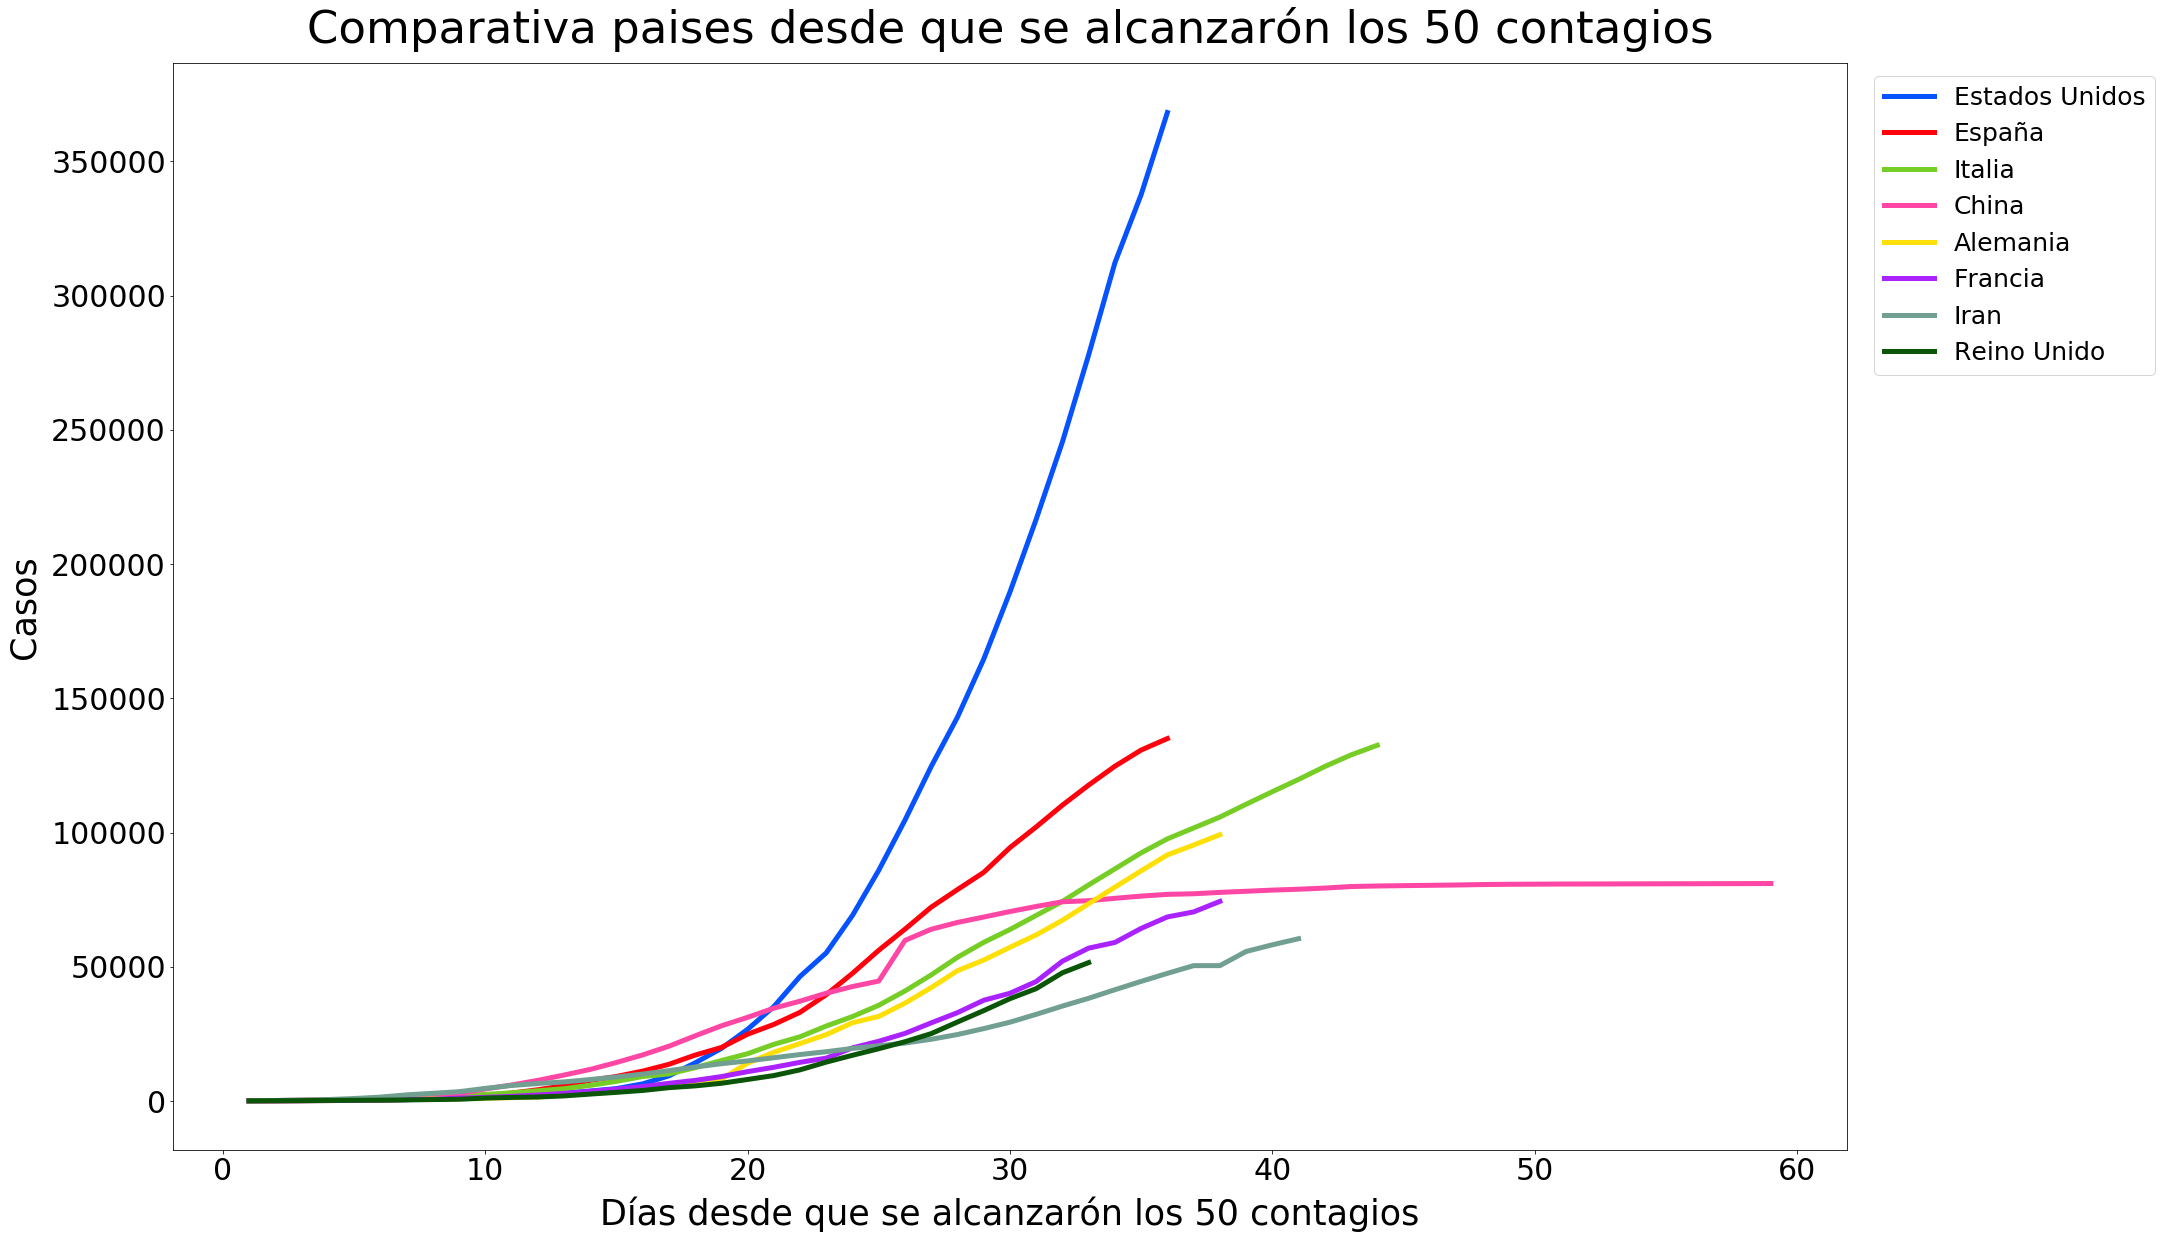

In [115]:
ax = plt.subplots(figsize=(30,20))

plt.plot(US['day_0'], US['casesacum'], label = 'Estados Unidos', linewidth=5, color = 'xkcd:electric blue')
plt.plot(ES['day_0'], ES['casesacum'], label = 'España', linewidth=5, color = 'xkcd:bright red')
plt.plot(IT['day_0'], IT['casesacum'], label = 'Italia', linewidth=5, color = 'xkcd:apple green')
plt.plot(CN['day_0'], CN['casesacum'], label = 'China', linewidth=5, color = 'xkcd:barbie pink') 
plt.plot(DE['day_0'], DE['casesacum'], label = 'Alemania', linewidth=5, color = 'xkcd:dandelion') 
plt.plot(FR['day_0'], FR['casesacum'], label = 'Francia', linewidth=5, color = 'xkcd:electric purple')
plt.plot(IR['day_0'], IR['casesacum'], label = 'Iran', linewidth=5, color = 'xkcd:greyish teal')
plt.plot(UK['day_0'], UK['casesacum'], label = 'Reino Unido', linewidth=5, color = 'xkcd:forest')
                
plt.legend(loc='upper left')

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')

plt.legend(prop = {'size':25}, loc = 'upper center', bbox_to_anchor=(1.1, 1))
    
plt.xlabel("Días desde que se alcanzarón los 50 contagios", fontsize=35, labelpad=10)
plt.ylabel("Casos", fontsize=35, labelpad=10)
plt.title("Comparativa paises desde que se alcanzarón los 50 contagios", fontsize=45, loc='center', pad=20)
plt.savefig("ComparativaPaisesDesde50Contagios", bbox_inches = "tight")
plt.show()

## Comparativa paises casos diarios COVID-19 contabilizando desde el contagiado 50

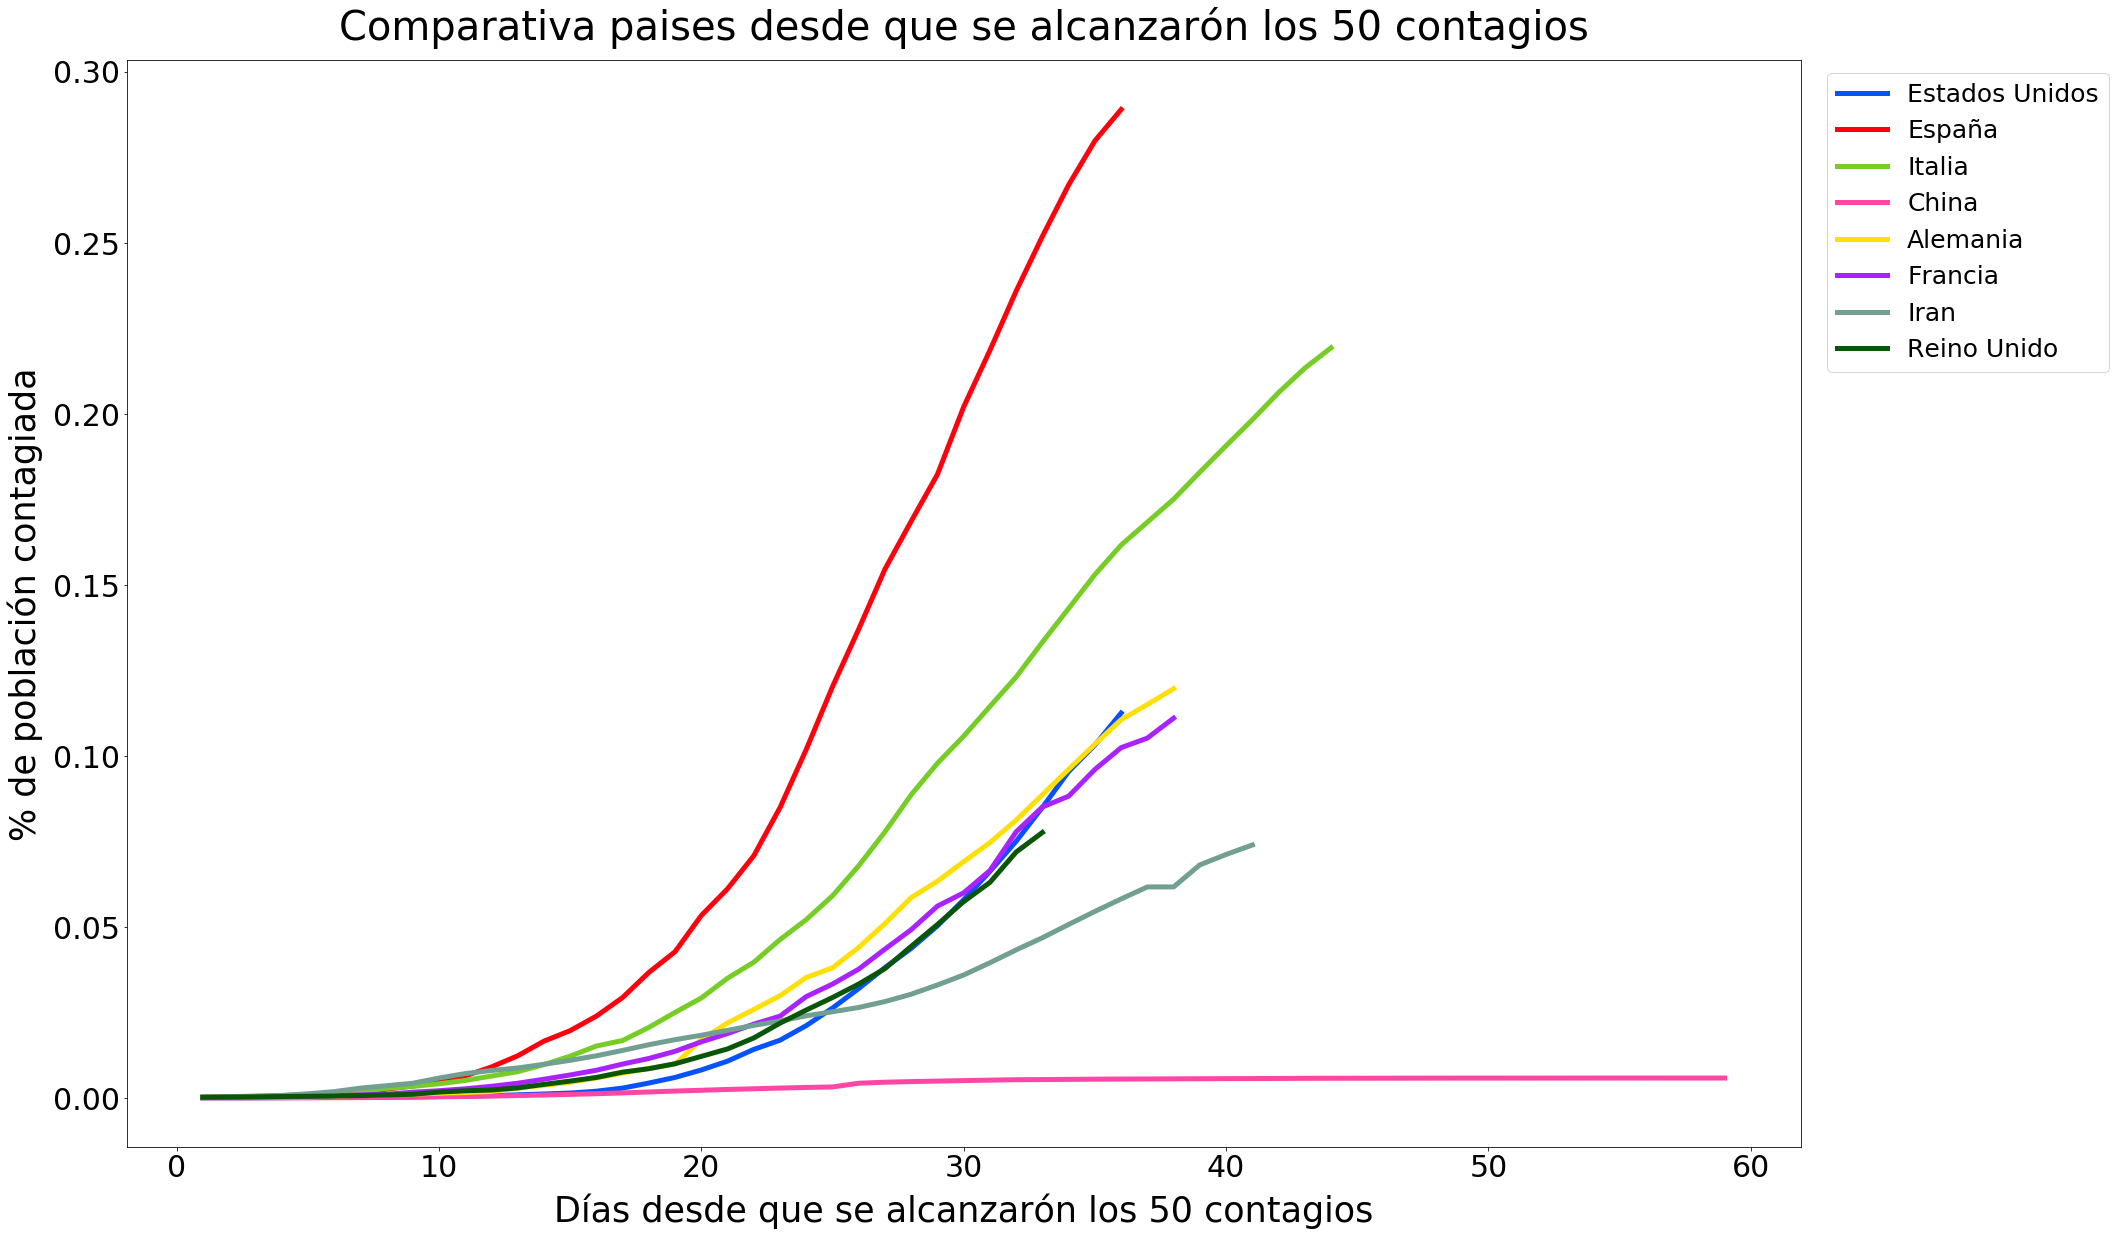

In [116]:
ax = plt.subplots(figsize=(30,20))

plt.plot(US['day_0'], US['%cases'], label = 'Estados Unidos', linewidth=5, color = 'xkcd:electric blue')
plt.plot(ES['day_0'], ES['%cases'], label = 'España', linewidth=5, color = 'xkcd:bright red')
plt.plot(IT['day_0'], IT['%cases'], label = 'Italia', linewidth=5, color = 'xkcd:apple green')
plt.plot(CN['day_0'], CN['%cases'], label = 'China', linewidth=5, color = 'xkcd:barbie pink') 
plt.plot(DE['day_0'], DE['%cases'], label = 'Alemania', linewidth=5, color = 'xkcd:dandelion') 
plt.plot(FR['day_0'], FR['%cases'], label = 'Francia', linewidth=5, color = 'xkcd:electric purple')
plt.plot(IR['day_0'], IR['%cases'], label = 'Iran', linewidth=5, color = 'xkcd:greyish teal')
plt.plot(UK['day_0'], UK['%cases'], label = 'Reino Unido', linewidth=5, color = 'xkcd:forest')
                
plt.legend(loc='upper left')

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')

plt.legend(prop = {'size':25}, loc = 'upper center', bbox_to_anchor=(1.1, 1))
    
plt.xlabel("Días desde que se alcanzarón los 50 contagios", fontsize=35, labelpad=10)
plt.ylabel("% de población contagiada", fontsize=35, labelpad=10)
plt.title("Comparativa paises desde que se alcanzarón los 50 contagios", fontsize=40, loc='center', pad=20)
plt.savefig("Comparativa%Desde50Contagios", bbox_inches = "tight")
plt.show()

# Estados Unidos

## Casos diarios

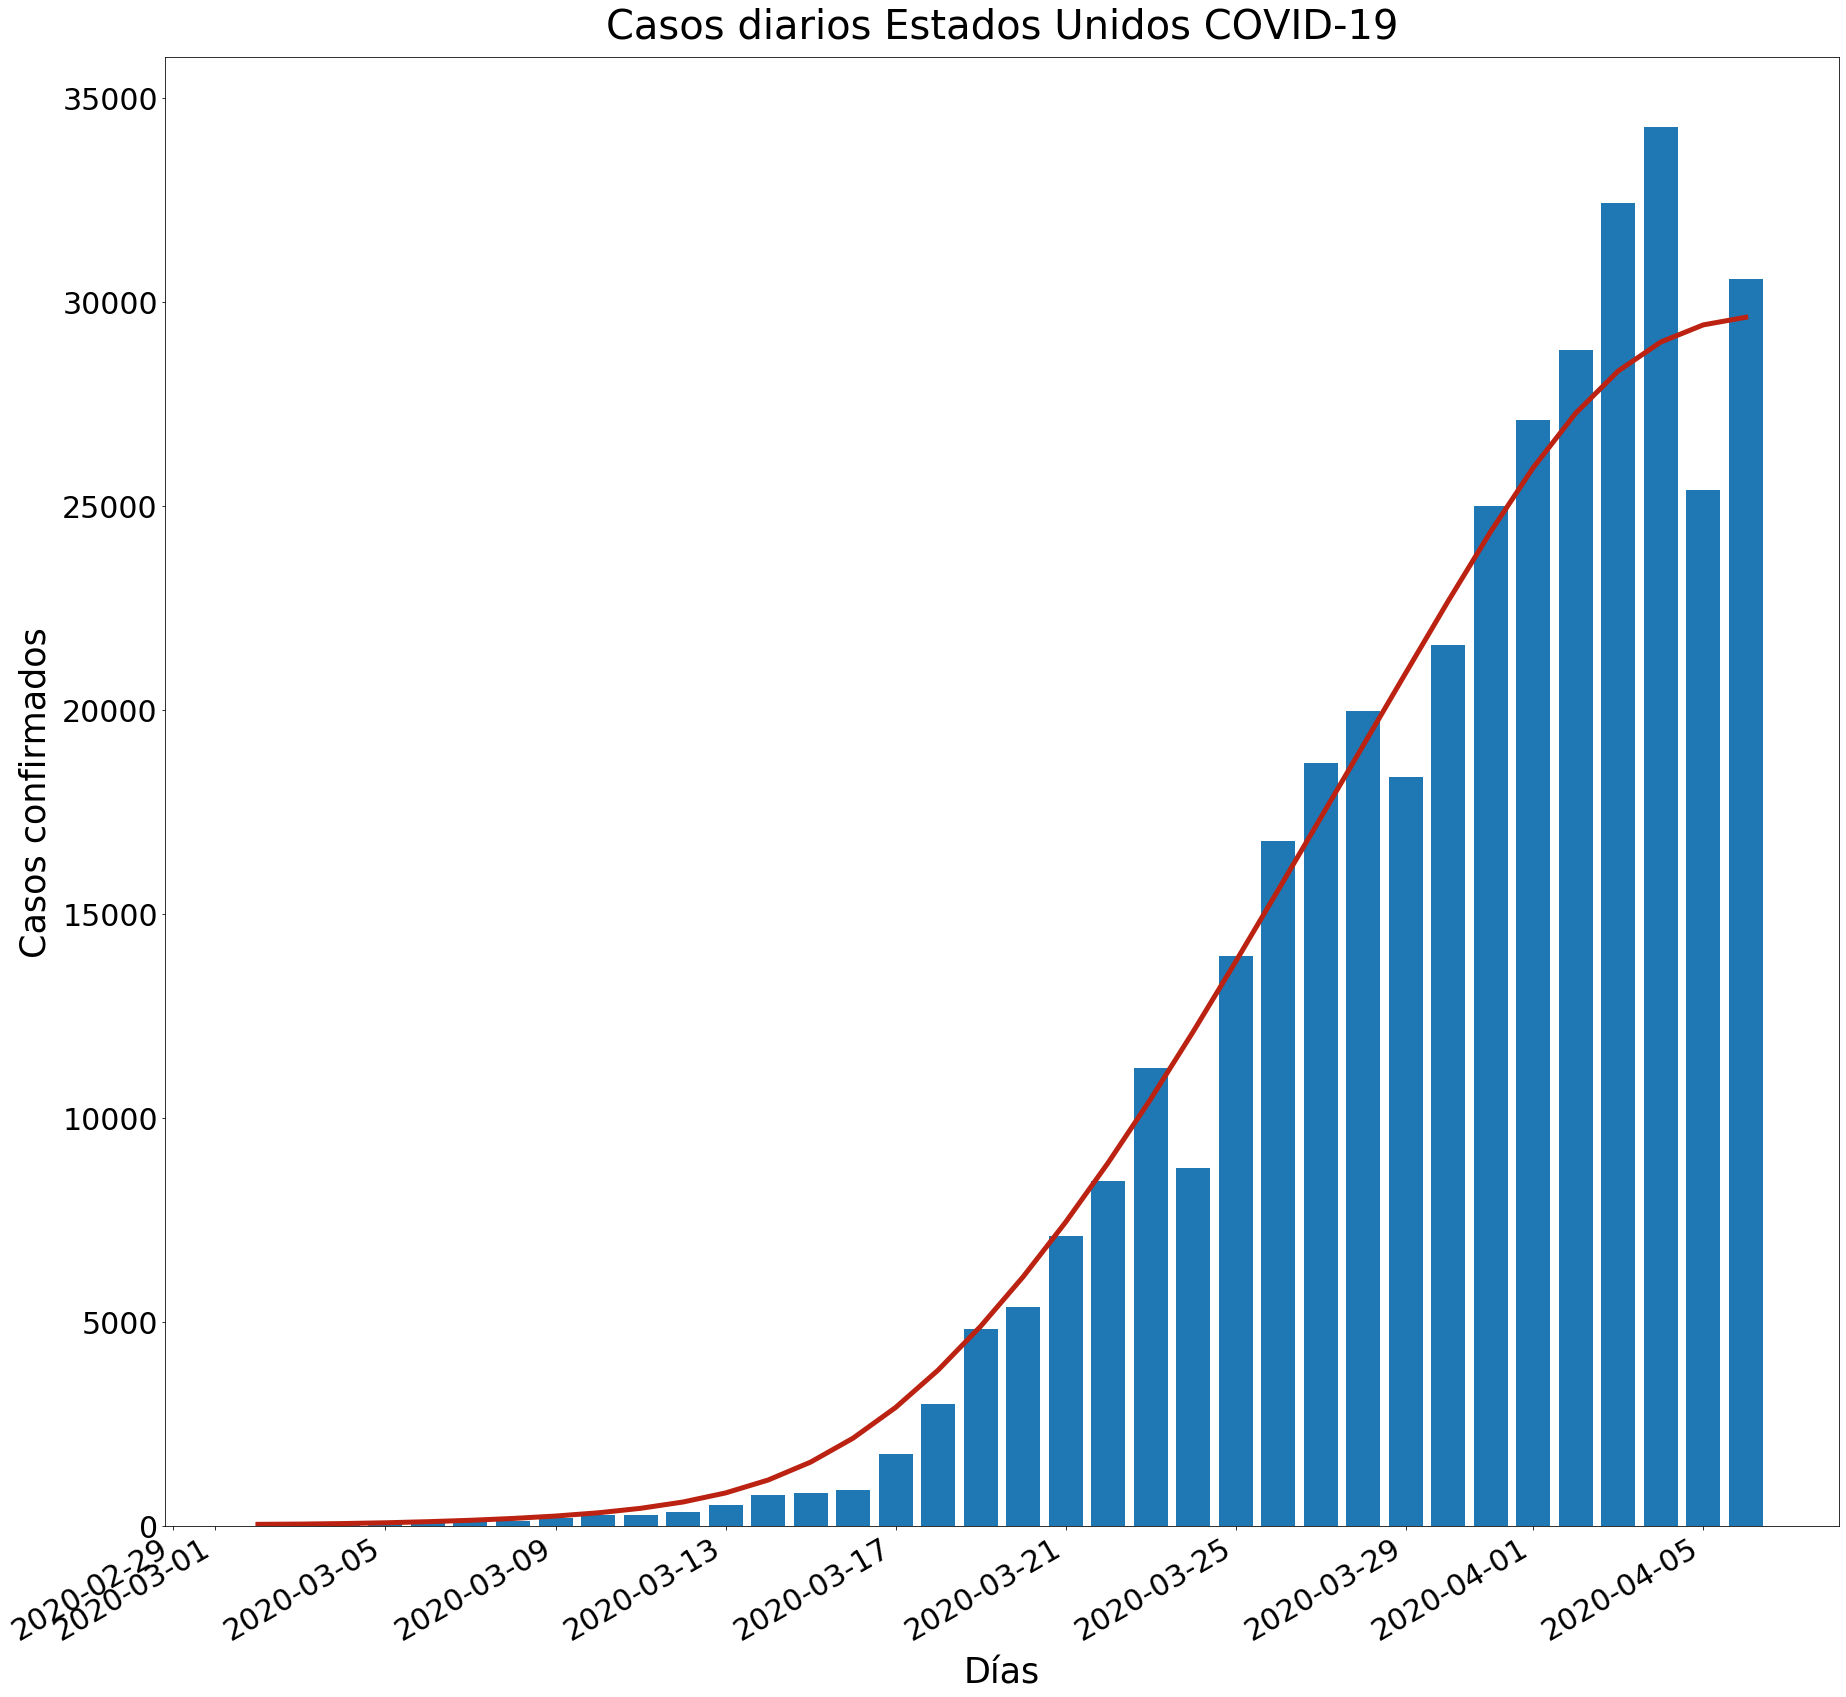

In [117]:
fig, ax =plt.subplots(figsize=(30,30))

plt.bar(US['dateRep'], US['cases'])
plt.plot(US['dateRep'], gaussian_filter1d(US['cases'], sigma=3),linewidth=5, color = '#BB2211')

fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Casos confirmados", fontsize=35, labelpad=10)
plt.title("Casos diarios Estados Unidos COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("CasosDiariosUS.jpg", bbox_inches = "tight")

plt.show()

## Ratio de contagio

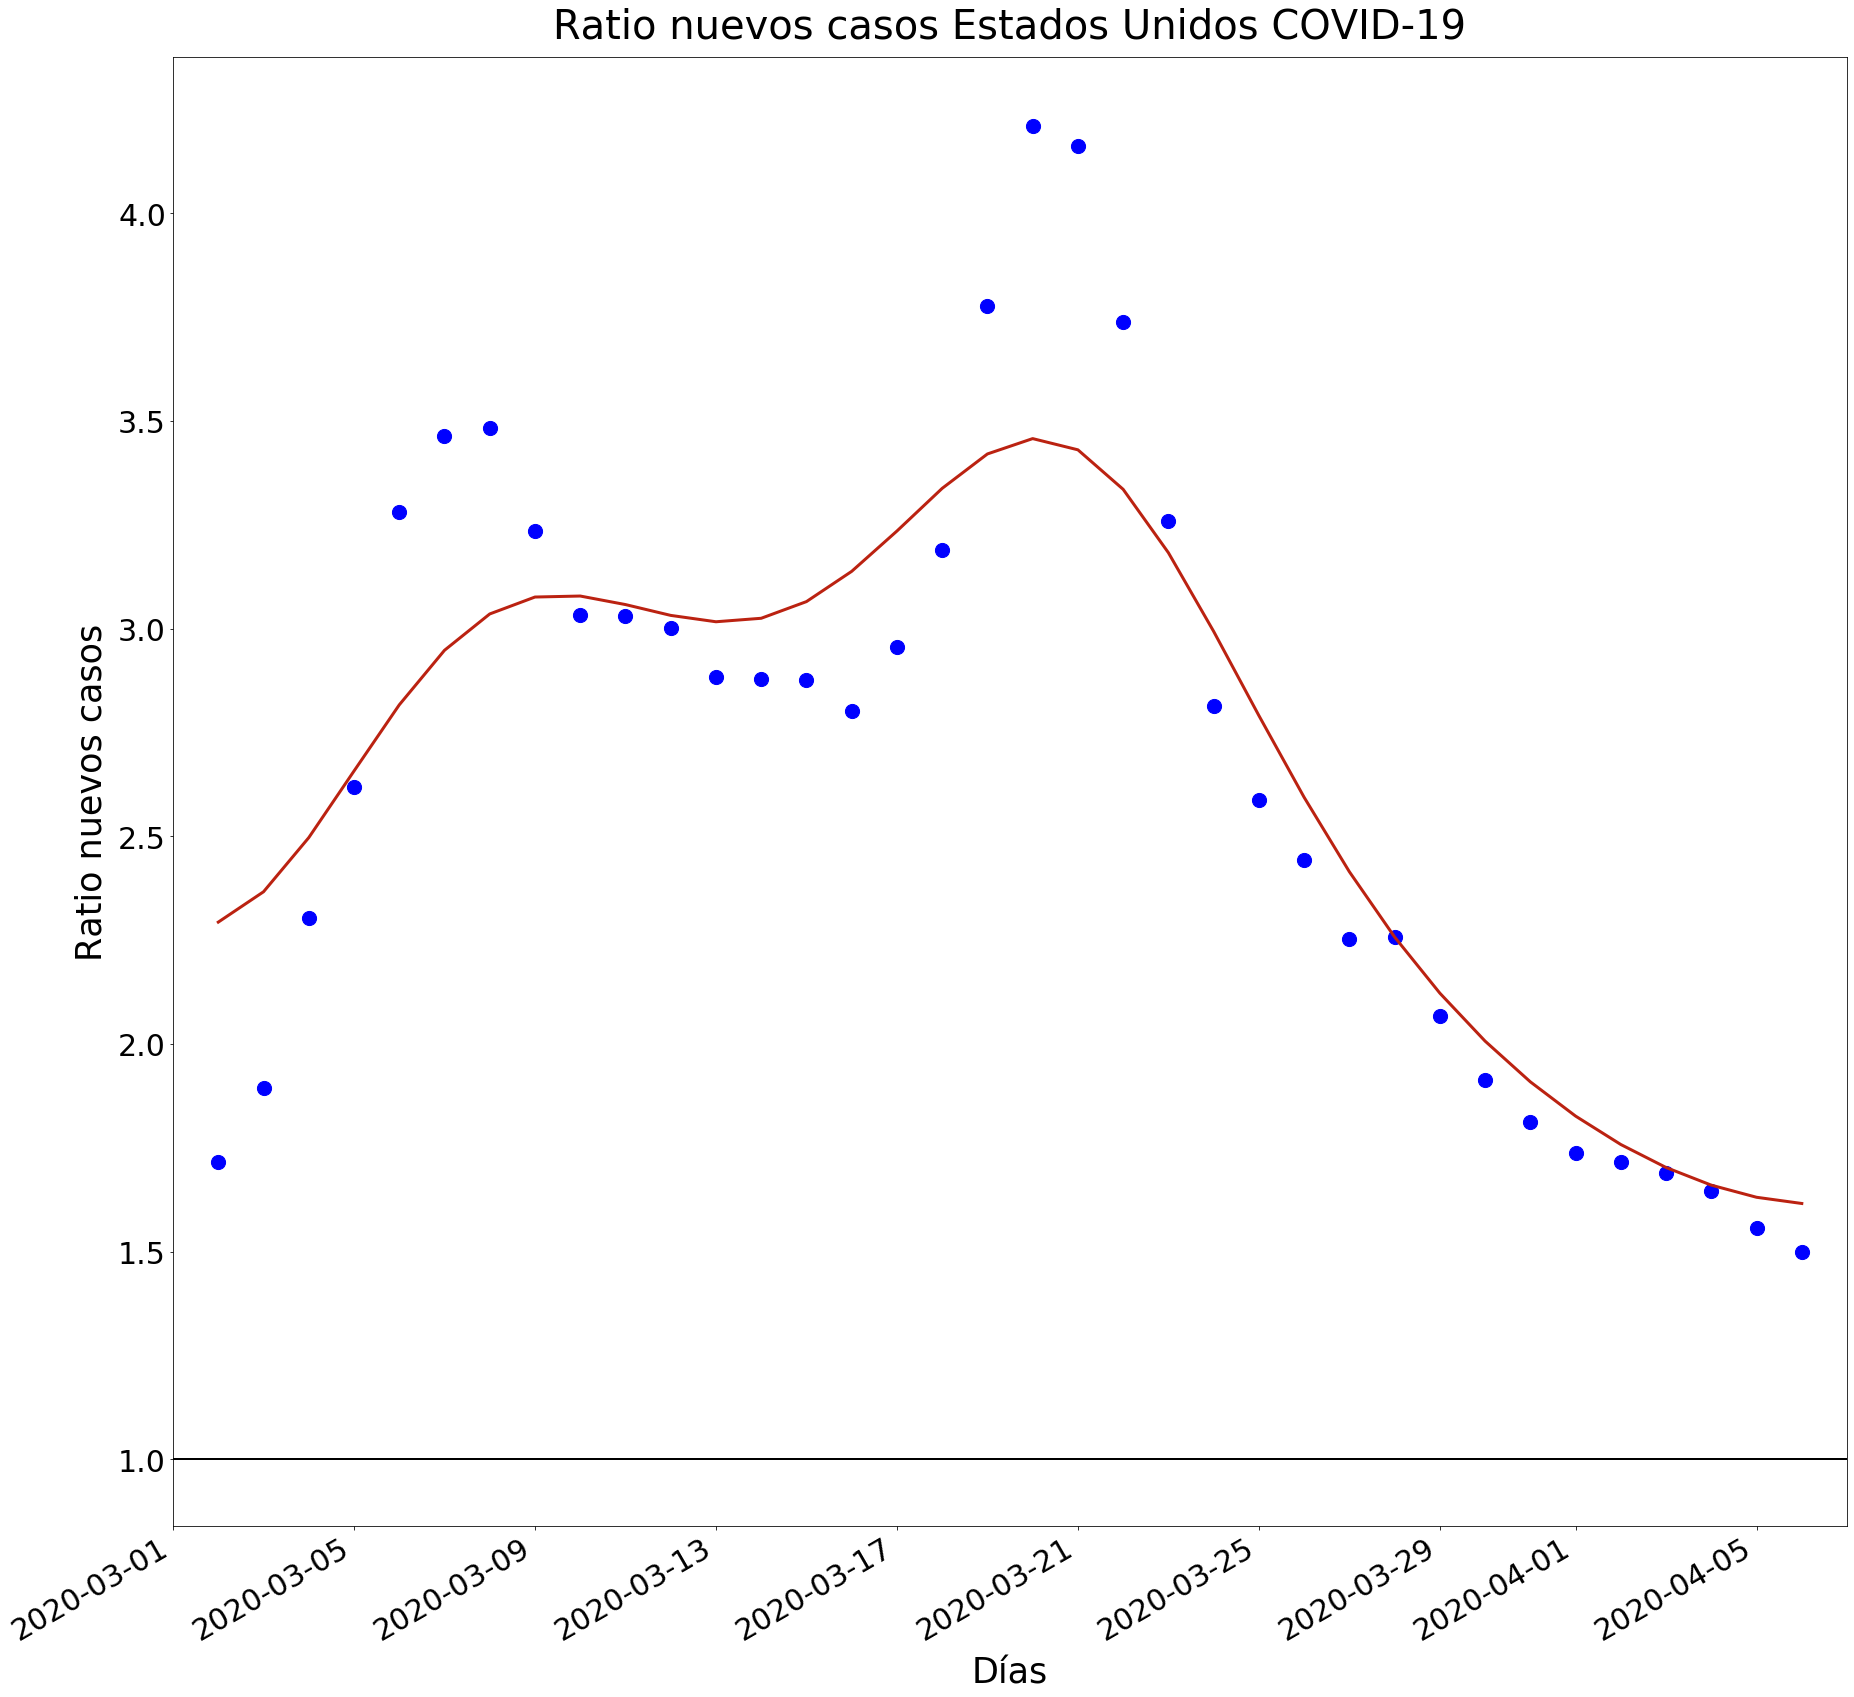

In [118]:
fig, ax =plt.subplots(figsize=(30,30))

plt.scatter(US['dateRep'], US['ratio4'],c='b',s=200)
plt.plot(US['dateRep'], gaussian_filter1d(US['ratio4'], sigma=3),linewidth=3, color = '#BB2211')

ax.set_xlim(np.min(US['dateRep'])- datetime.timedelta(days=1), np.max(US['dateRep'])+ datetime.timedelta(days=1))
ax.axhline(linewidth=2, color='black', y=1)
fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Ratio nuevos casos", fontsize=35, labelpad=10)
plt.title("Ratio nuevos casos Estados Unidos COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("RatioCasosUS.jpg", bbox_inches = "tight")

plt.show()

# España

## Casos diarios

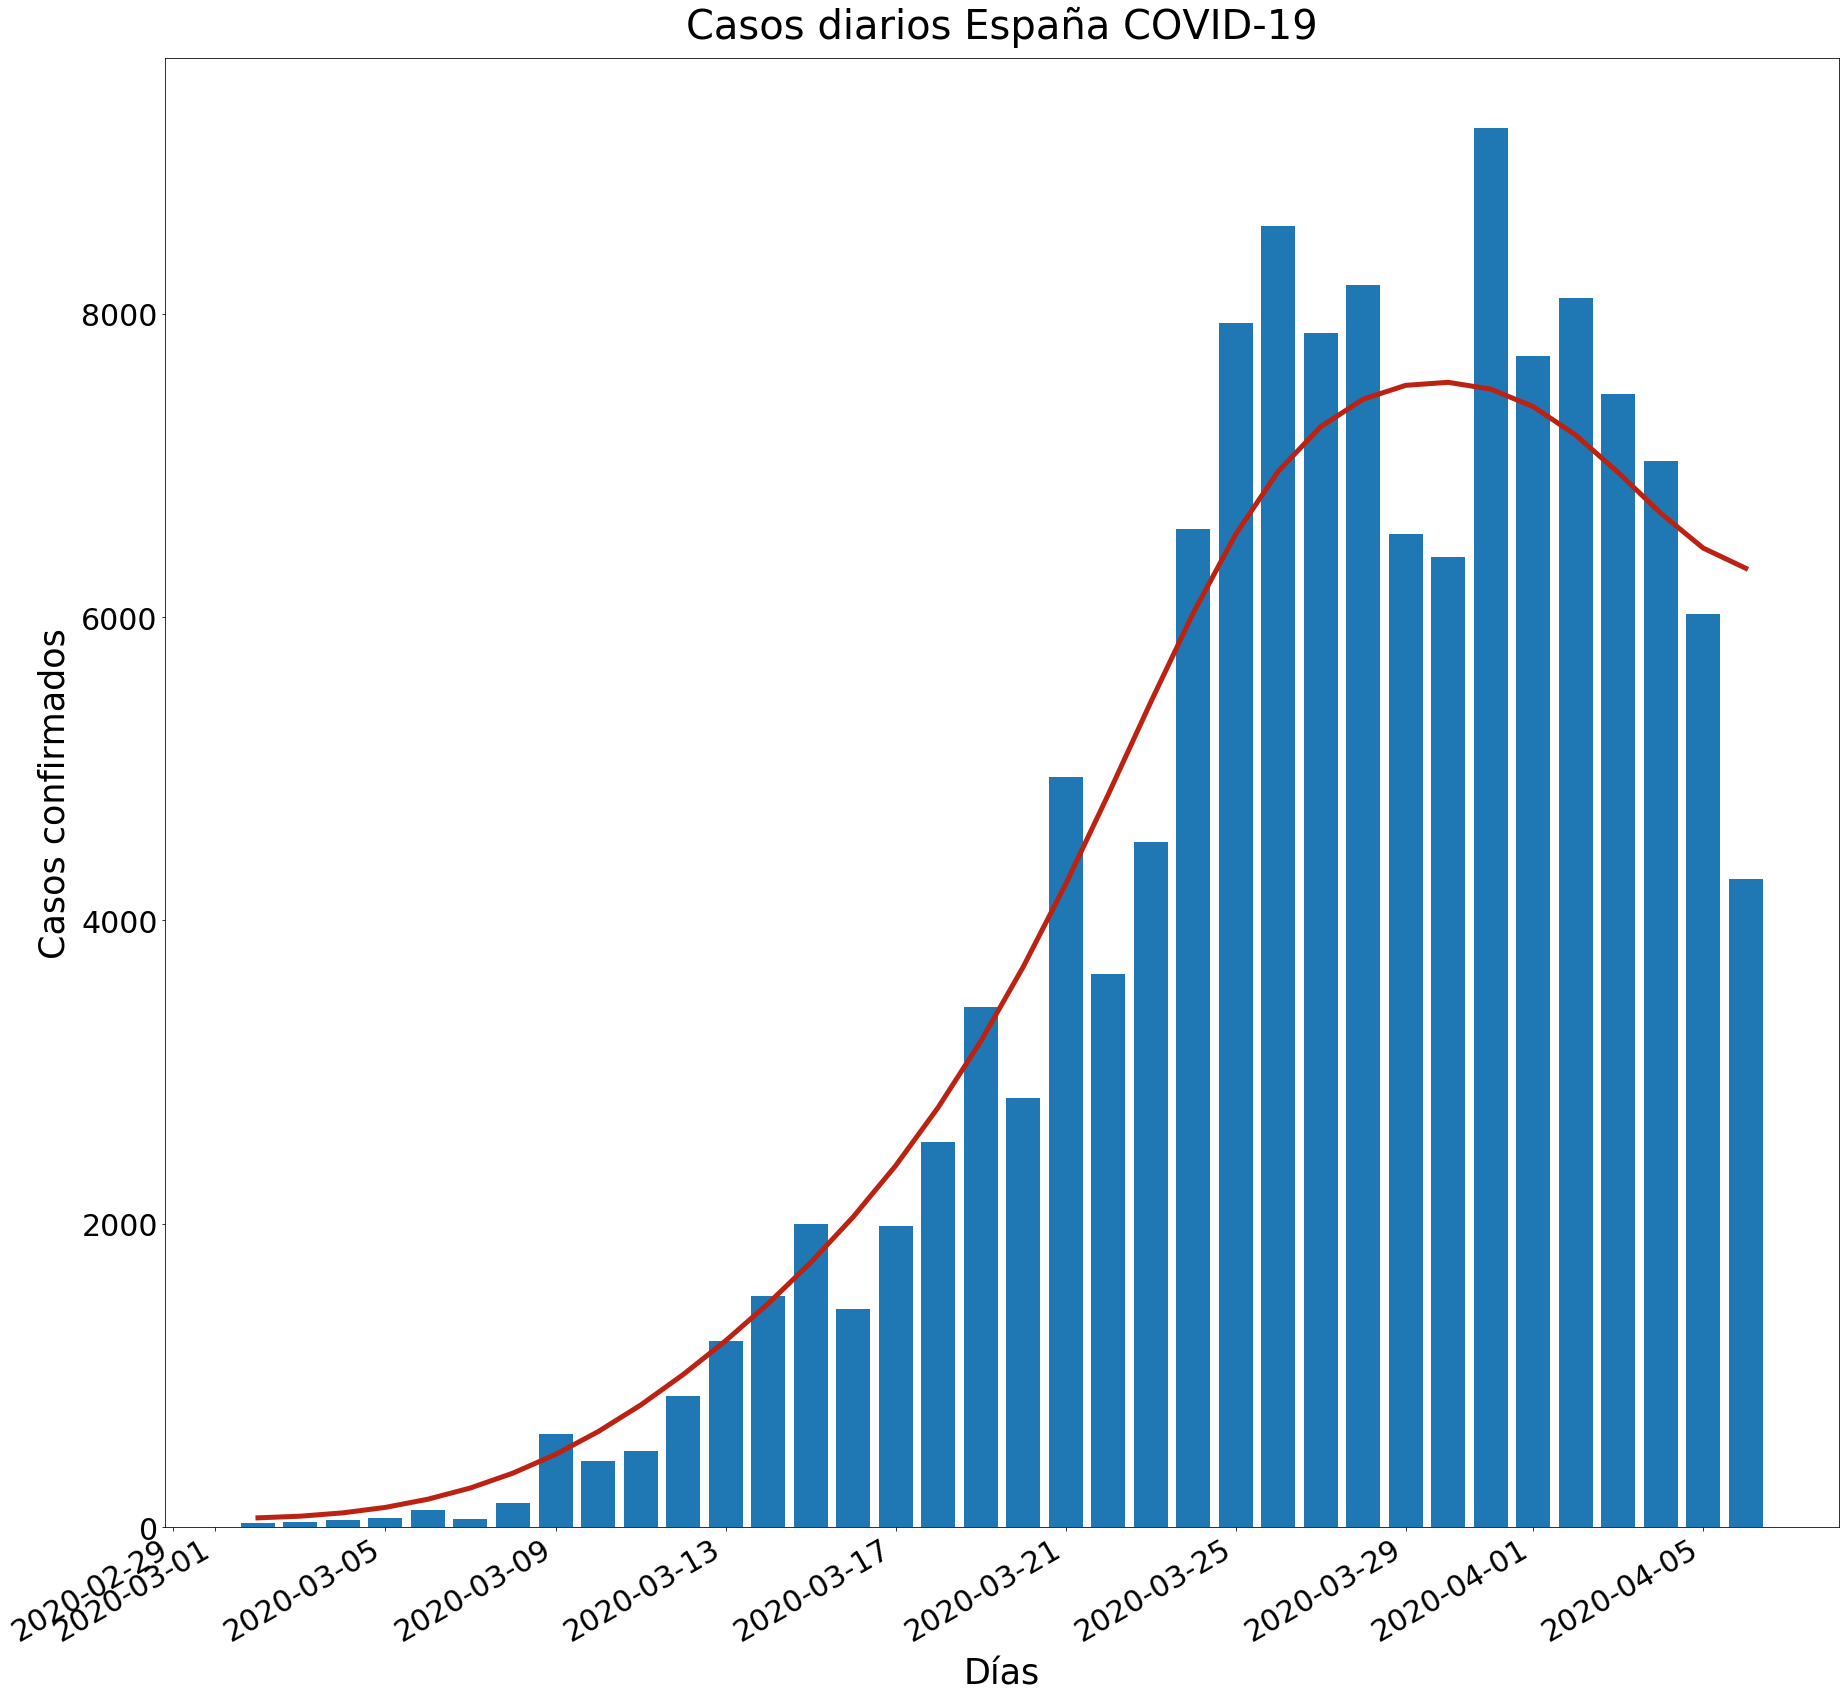

In [119]:
fig, ax =plt.subplots(figsize=(30,30))

plt.bar(ES['dateRep'], ES['cases'])
plt.plot(ES['dateRep'], gaussian_filter1d(ES['cases'], sigma=3),linewidth=5, color = '#BB2211')

fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Casos confirmados", fontsize=35, labelpad=10)
plt.title("Casos diarios España COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("CasosDiariosES.jpg", bbox_inches = "tight")

plt.show()

## Ratio de contagio

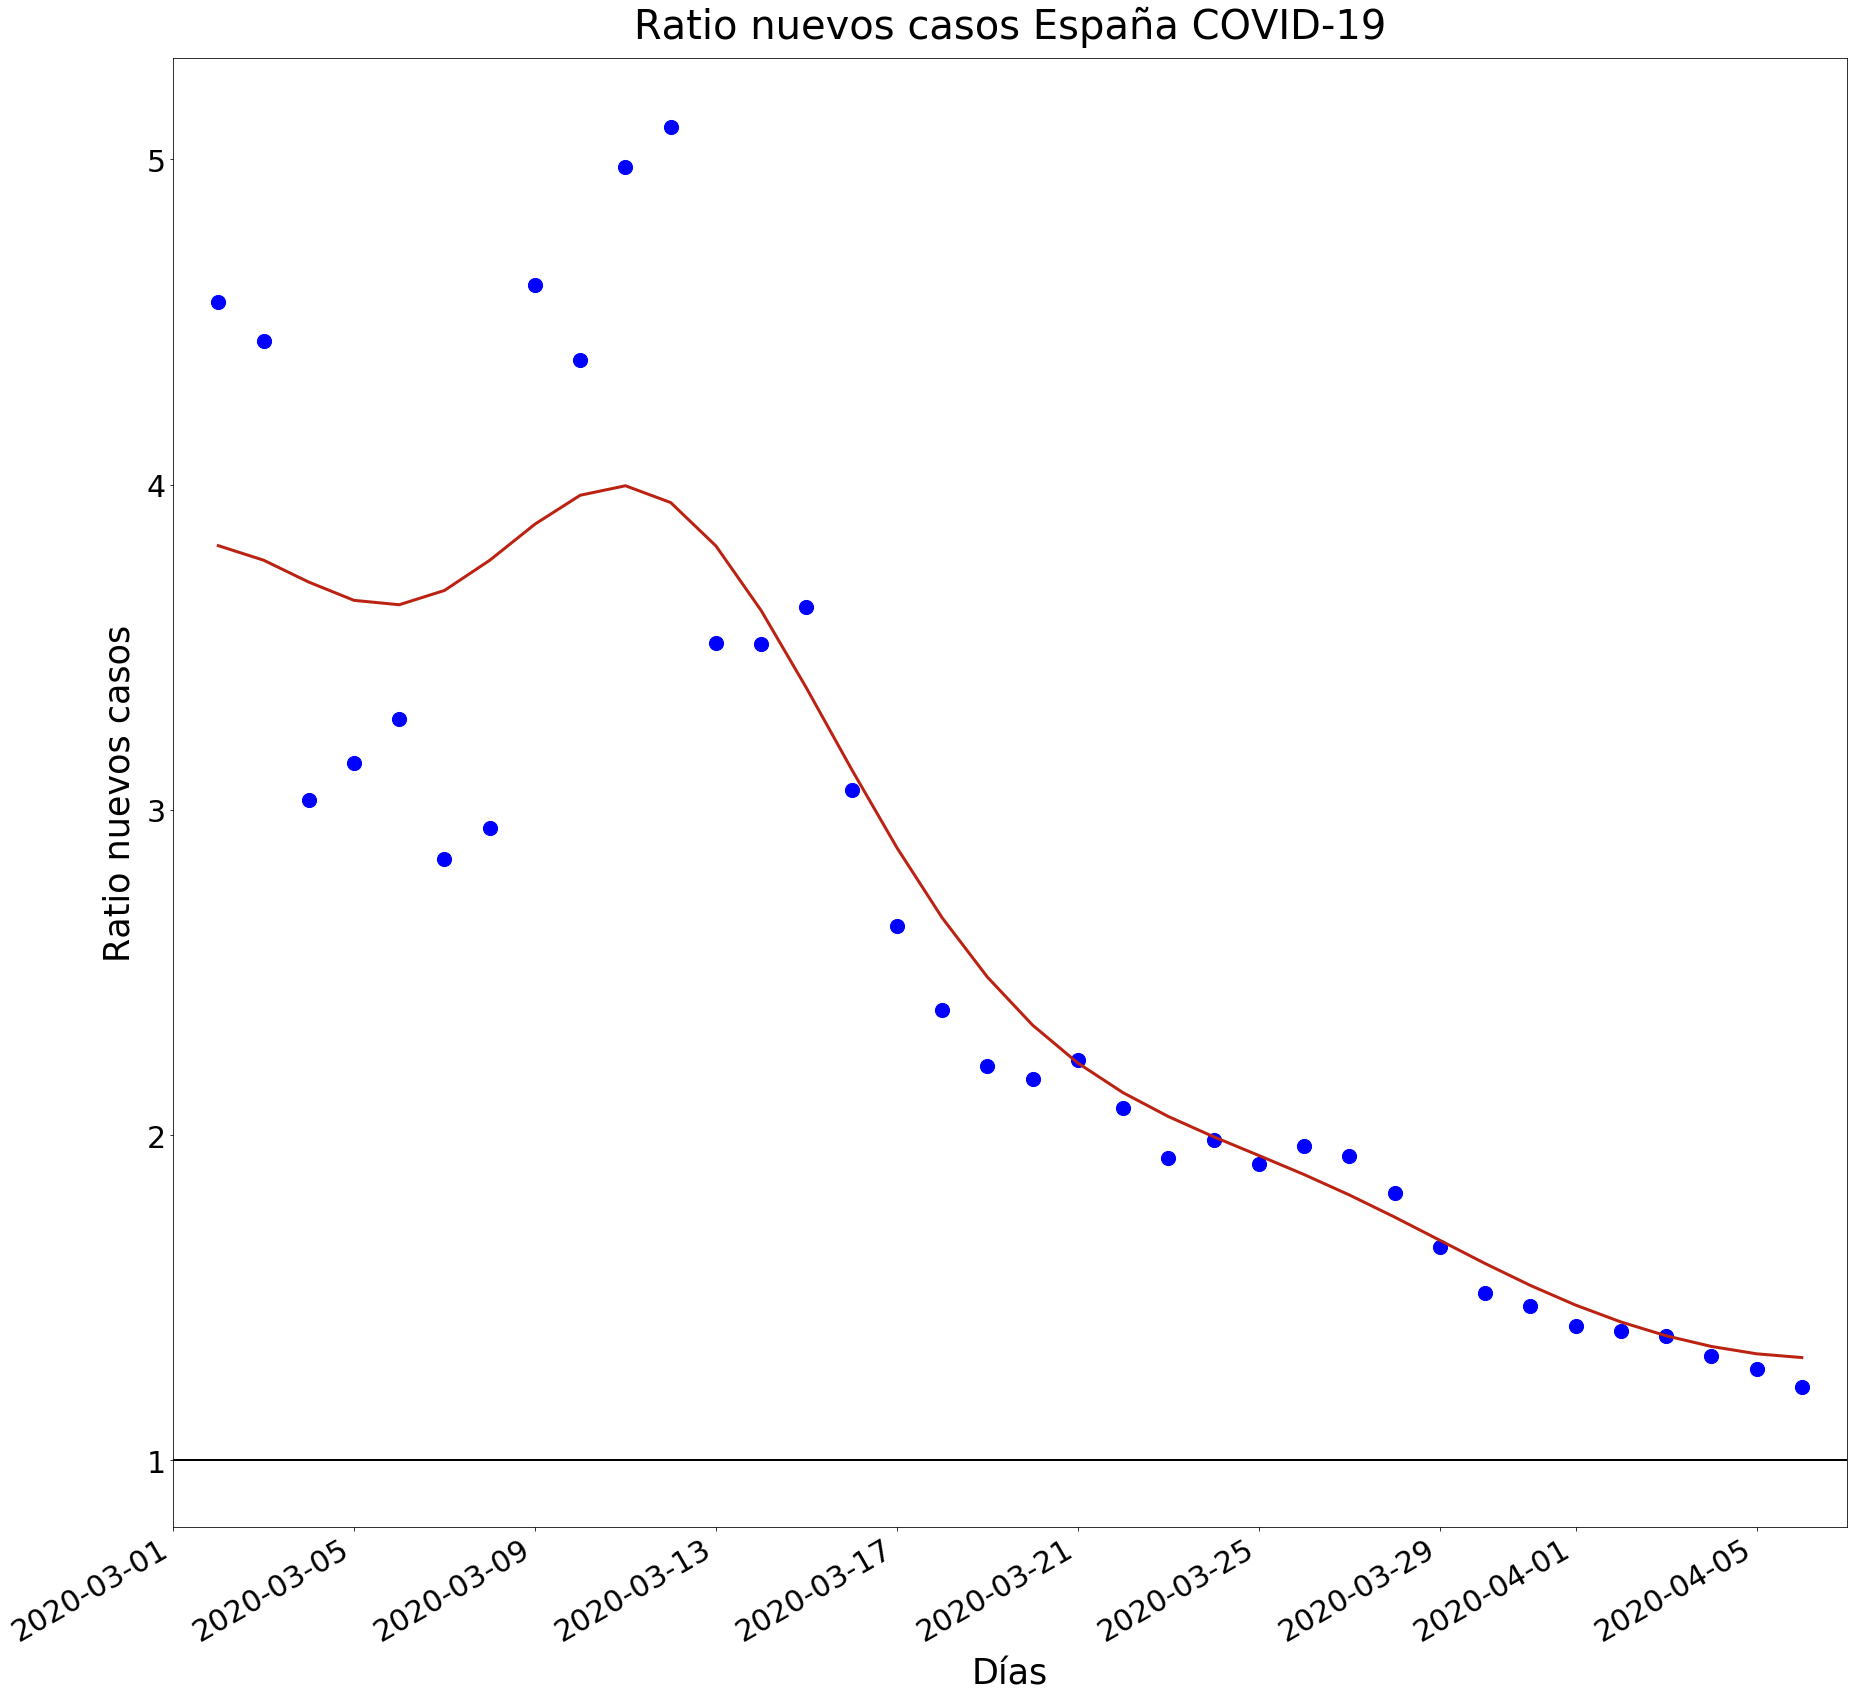

In [120]:
fig, ax =plt.subplots(figsize=(30,30))

plt.scatter(ES['dateRep'], ES['ratio4'],c='b',s=200)
plt.plot(ES['dateRep'], gaussian_filter1d(ES['ratio4'], sigma=3),linewidth=3, color = '#BB2211')

ax.set_xlim(np.min(ES['dateRep'])- datetime.timedelta(days=1), np.max(ES['dateRep'])+ datetime.timedelta(days=1))
ax.axhline(linewidth=2, color='black', y=1)
fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Ratio nuevos casos", fontsize=35, labelpad=10)
plt.title("Ratio nuevos casos España COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("RatioCasosES.jpg", bbox_inches = "tight")

plt.show()

# Italia

## Casos diarios

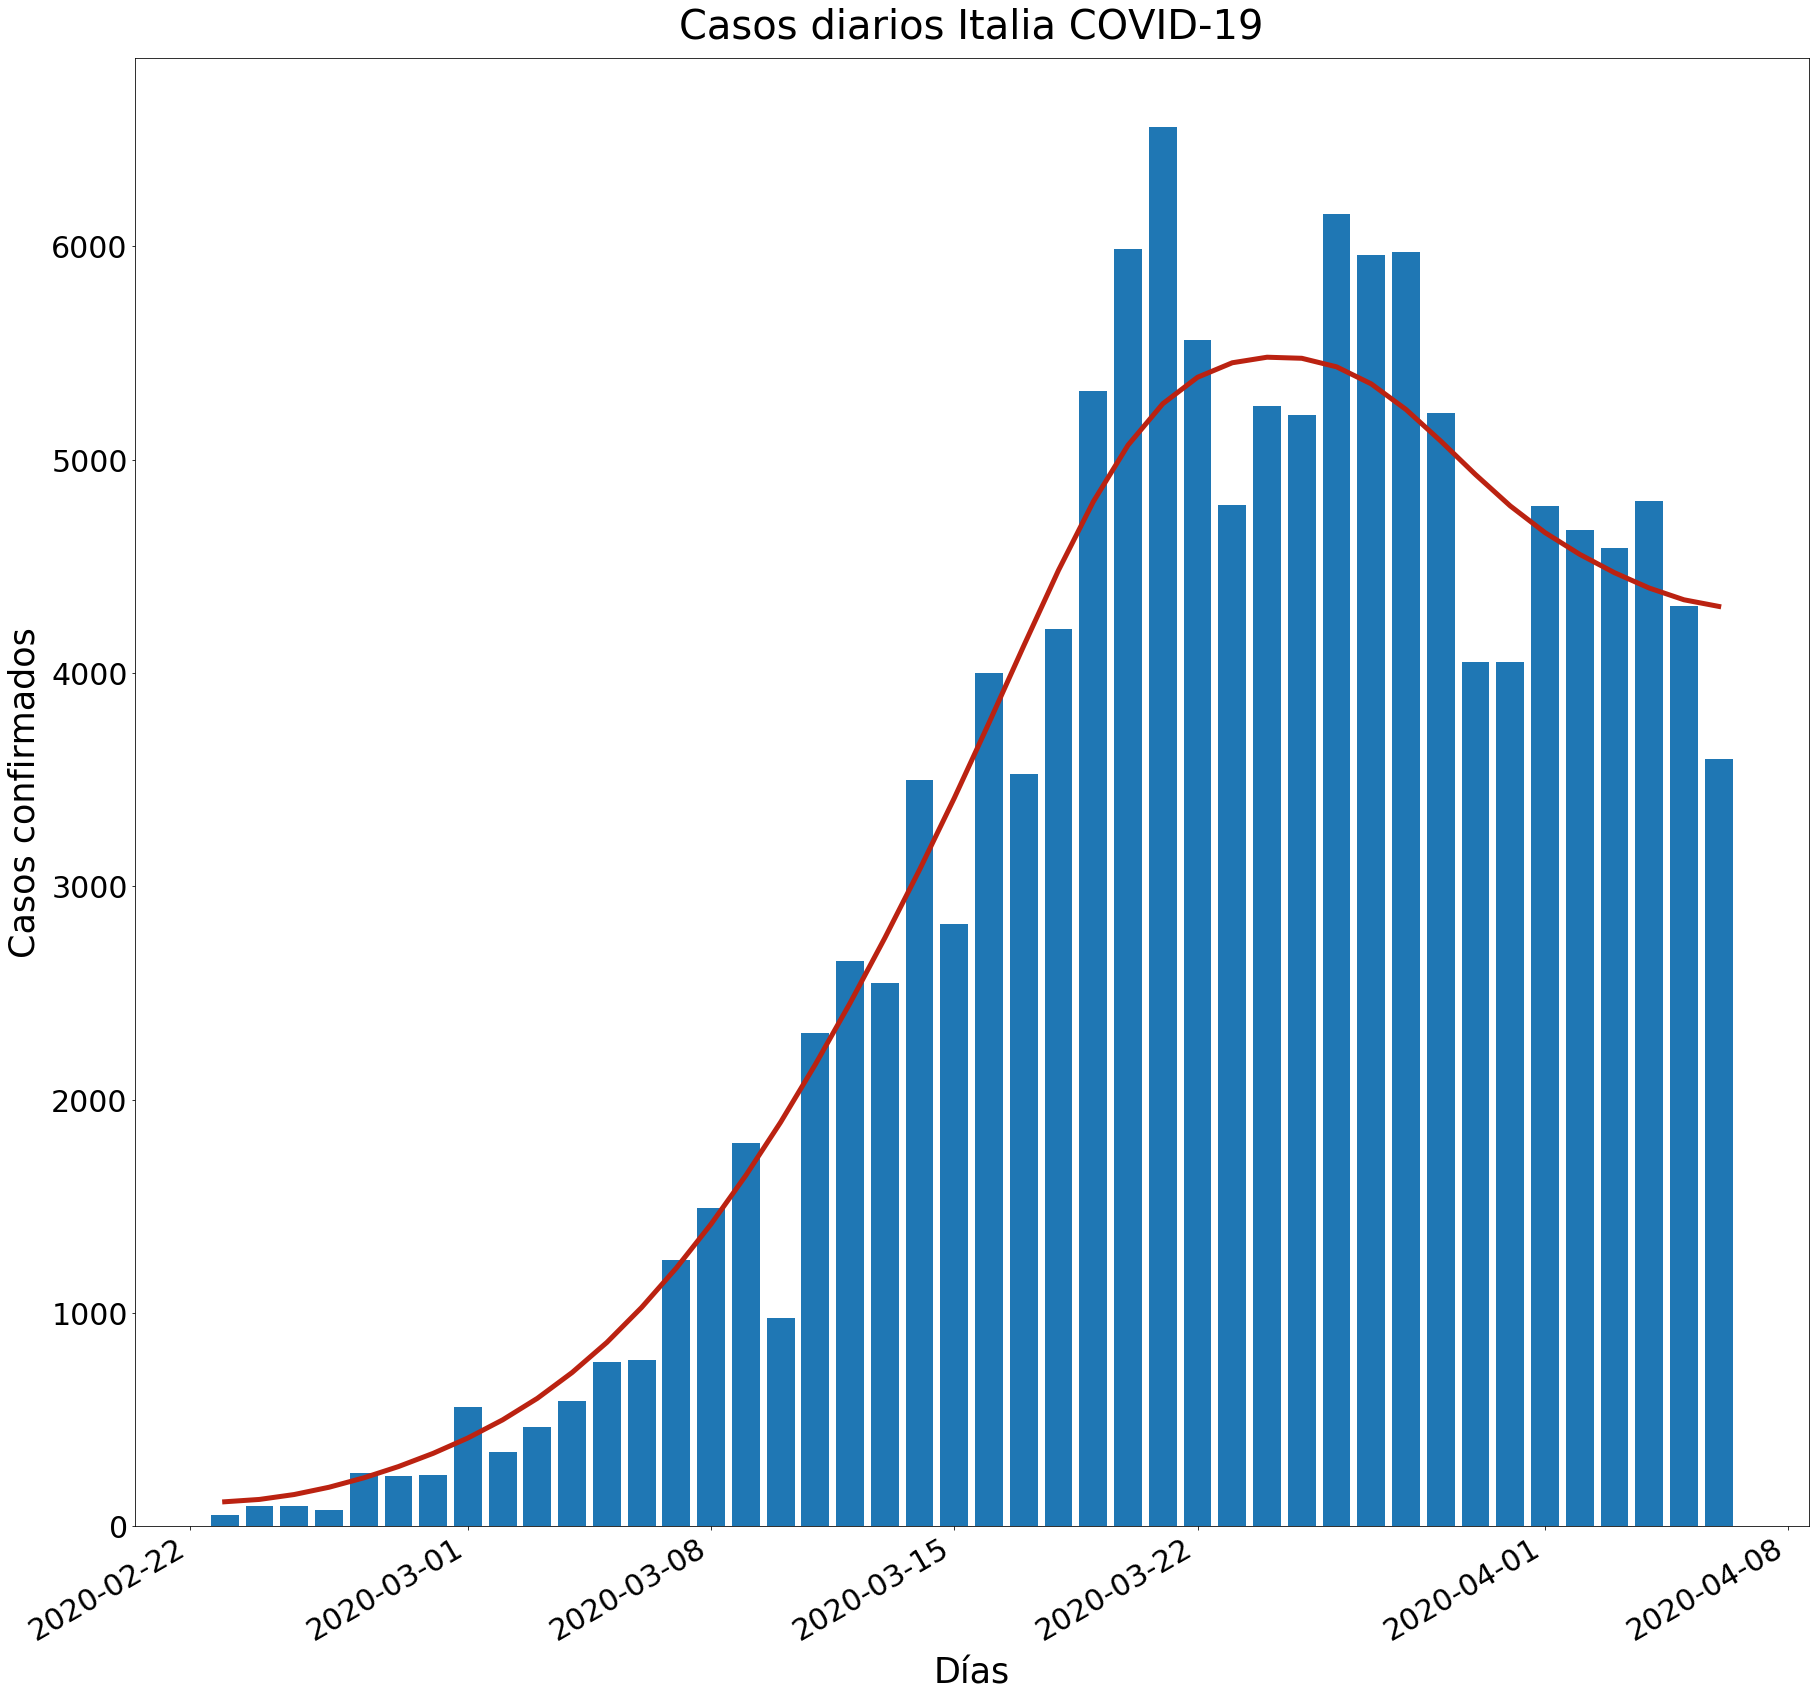

In [121]:
fig, ax =plt.subplots(figsize=(30,30))

plt.bar(IT['dateRep'], IT['cases'])
plt.plot(IT['dateRep'], gaussian_filter1d(IT['cases'], sigma=3),linewidth=5, color = '#BB2211')

fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Casos confirmados", fontsize=35, labelpad=10)
plt.title("Casos diarios Italia COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("CasosDiariosIT.jpg", bbox_inches = "tight")

plt.show()

## Ratio de contagio

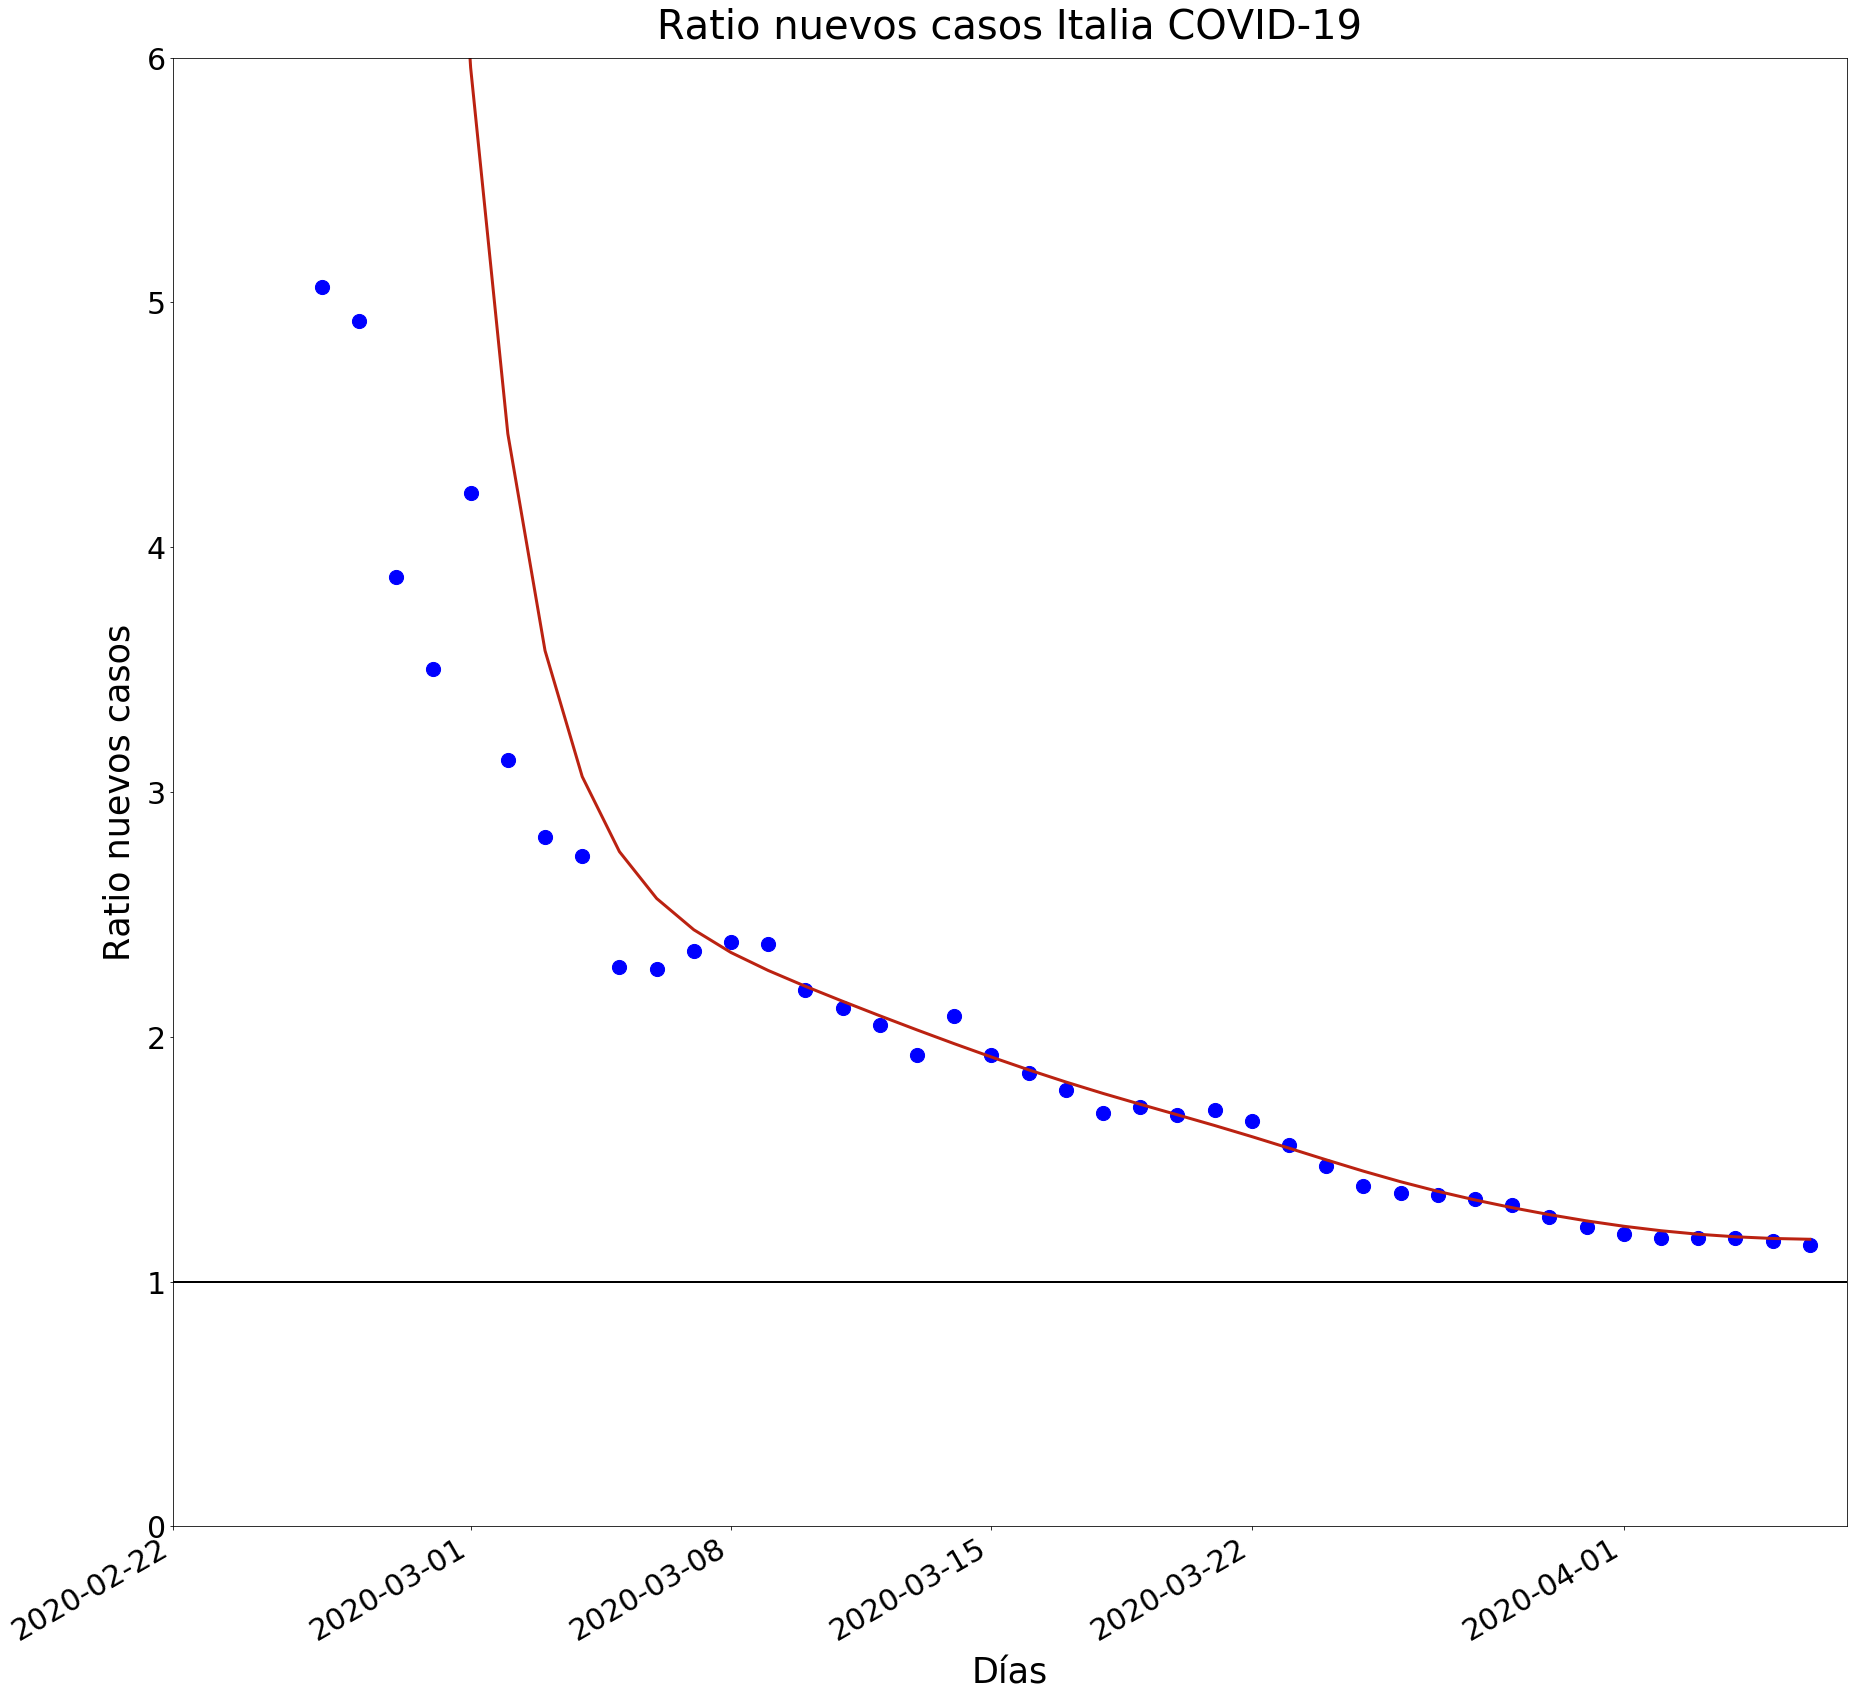

In [122]:
fig, ax =plt.subplots(figsize=(30,30))

plt.scatter(IT['dateRep'], IT['ratio4'],c='b',s=200)
plt.plot(IT['dateRep'], gaussian_filter1d(IT['ratio4'], sigma=3),linewidth=3, color = '#BB2211')

ax.set_xlim(np.min(IT['dateRep'])- datetime.timedelta(days=1), np.max(IT['dateRep'])+ datetime.timedelta(days=1))
ax.axhline(linewidth=2, color='black', y=1)
fig.autofmt_xdate()

ax.set_ylim(0,6)

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Ratio nuevos casos", fontsize=35, labelpad=10)
plt.title("Ratio nuevos casos Italia COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("RatioCasosIT.jpg", bbox_inches = "tight")

plt.show()

# Mundial

In [123]:
acumulados = data.groupby(['dateRep']).agg({'cases':'sum', 'deaths':'sum'}).reset_index()
acumulados = acumulados.sort_values(by=['dateRep'], ascending=True)
acumulados['casesacum'] = acumulados['cases'].transform(pd.Series.cumsum)
acumulados['4_days'] = acumulados['casesacum'].shift(4)
acumulados['ratio4'] = acumulados['casesacum']/acumulados['4_days']
acumulados = acumulados[(acumulados['dateRep'] > '15/01/2020')]

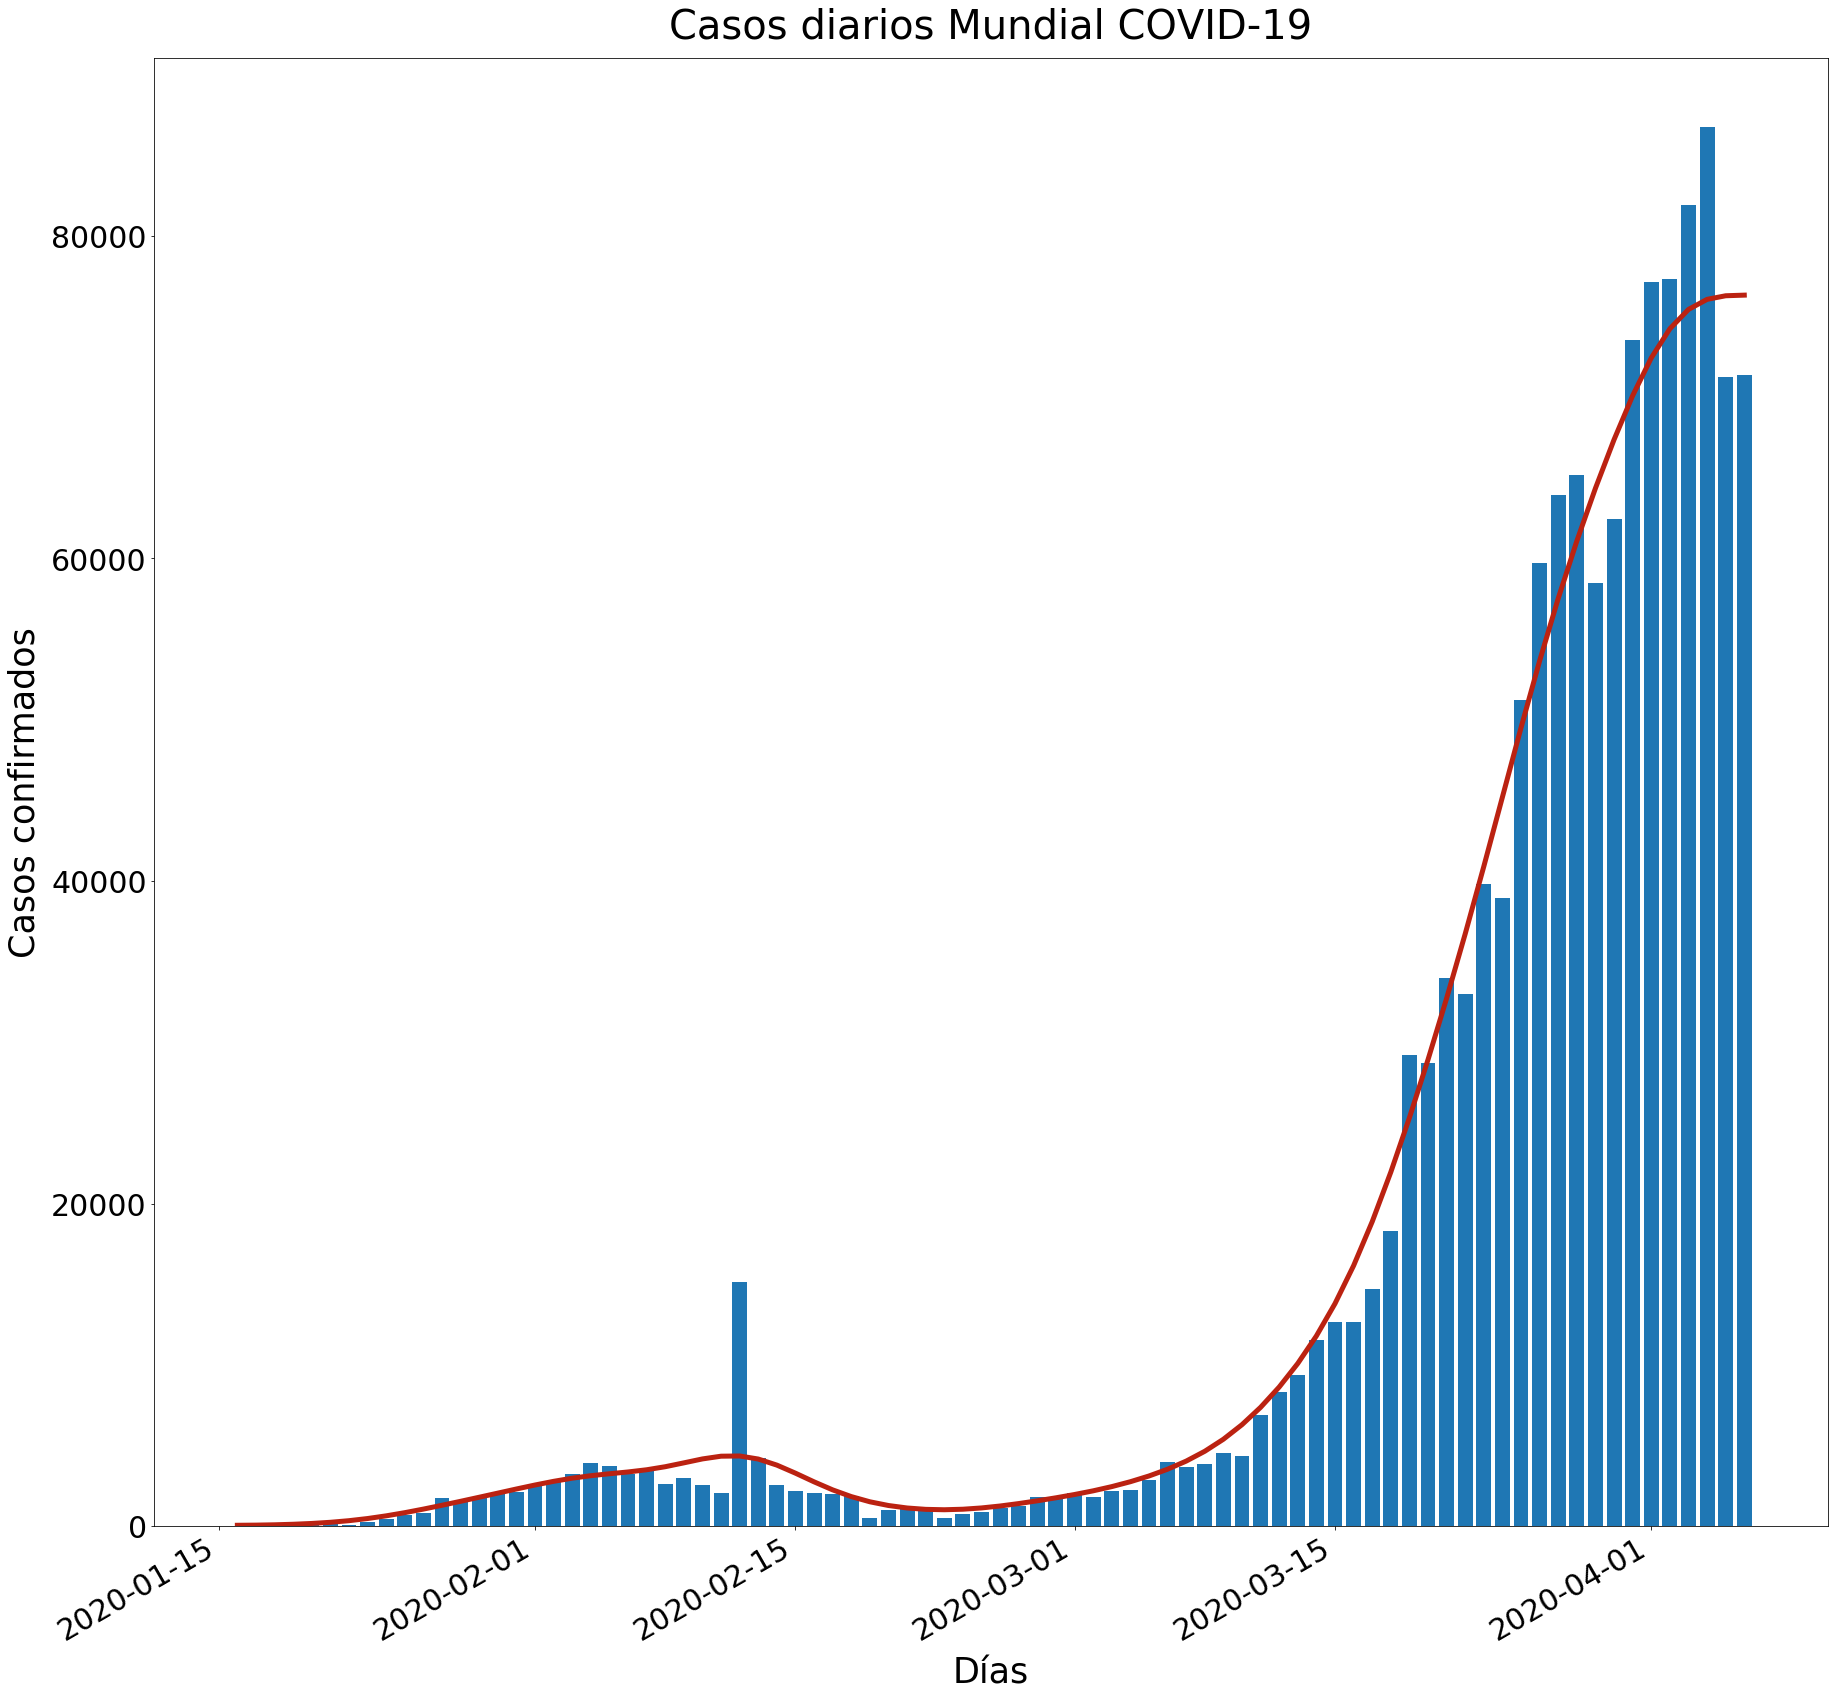

In [124]:
fig, ax =plt.subplots(figsize=(30,30))

plt.bar(acumulados['dateRep'], acumulados['cases'])
plt.plot(acumulados['dateRep'], gaussian_filter1d(acumulados['cases'], sigma=3),linewidth=5, color = '#BB2211')

fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Casos confirmados", fontsize=35, labelpad=10)
plt.title("Casos diarios Mundial COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("CasosDiariosMundial.jpg", bbox_inches = "tight")

plt.show()

## Ratio de contagio

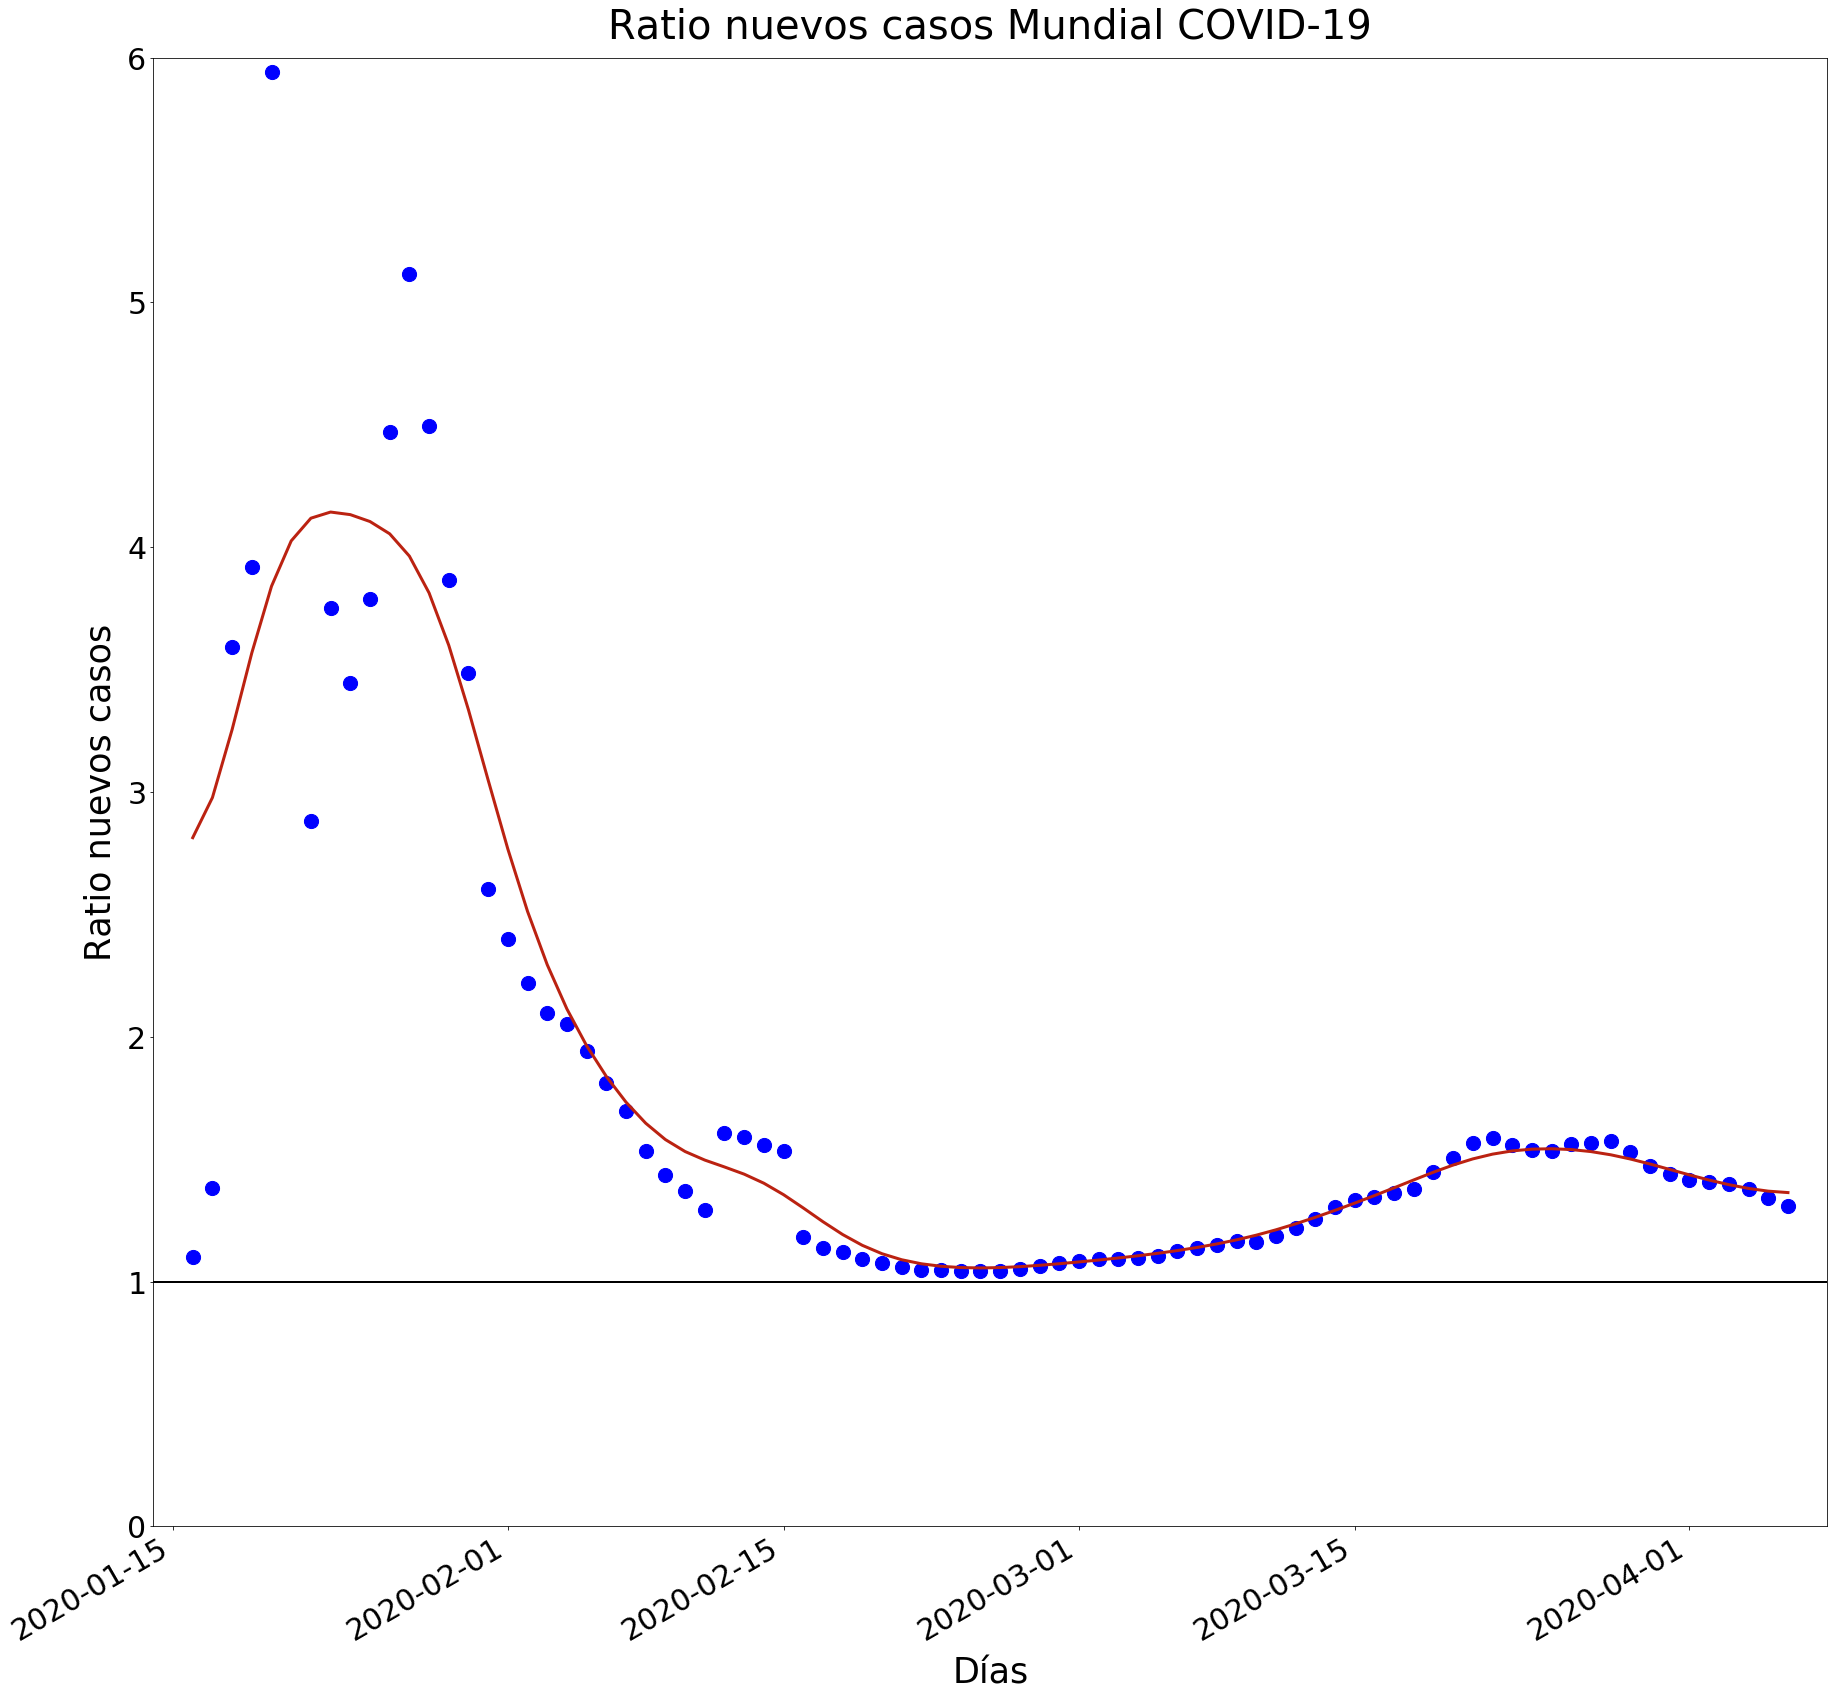

In [125]:
fig, ax =plt.subplots(figsize=(30,30))

plt.scatter(acumulados['dateRep'], acumulados['ratio4'],c='b',s=200)
plt.plot(acumulados['dateRep'], gaussian_filter1d(acumulados['ratio4'], sigma=3),linewidth=3, color = '#BB2211')

ax.set_xlim(np.min(acumulados['dateRep'])- datetime.timedelta(days=2), np.max(acumulados['dateRep'])+ datetime.timedelta(days=2))
ax.axhline(linewidth=2, color='black', y=1)
ax.set_ylim(0,6)
fig.autofmt_xdate()

plt.xticks(fontsize='30')
plt.yticks(fontsize='30')
plt.xlabel("Días", fontsize=35, labelpad=10)
plt.ylabel("Ratio nuevos casos", fontsize=35, labelpad=10)
plt.title("Ratio nuevos casos Mundial COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("RatioCasosMundial.jpg", bbox_inches = "tight")

plt.show()

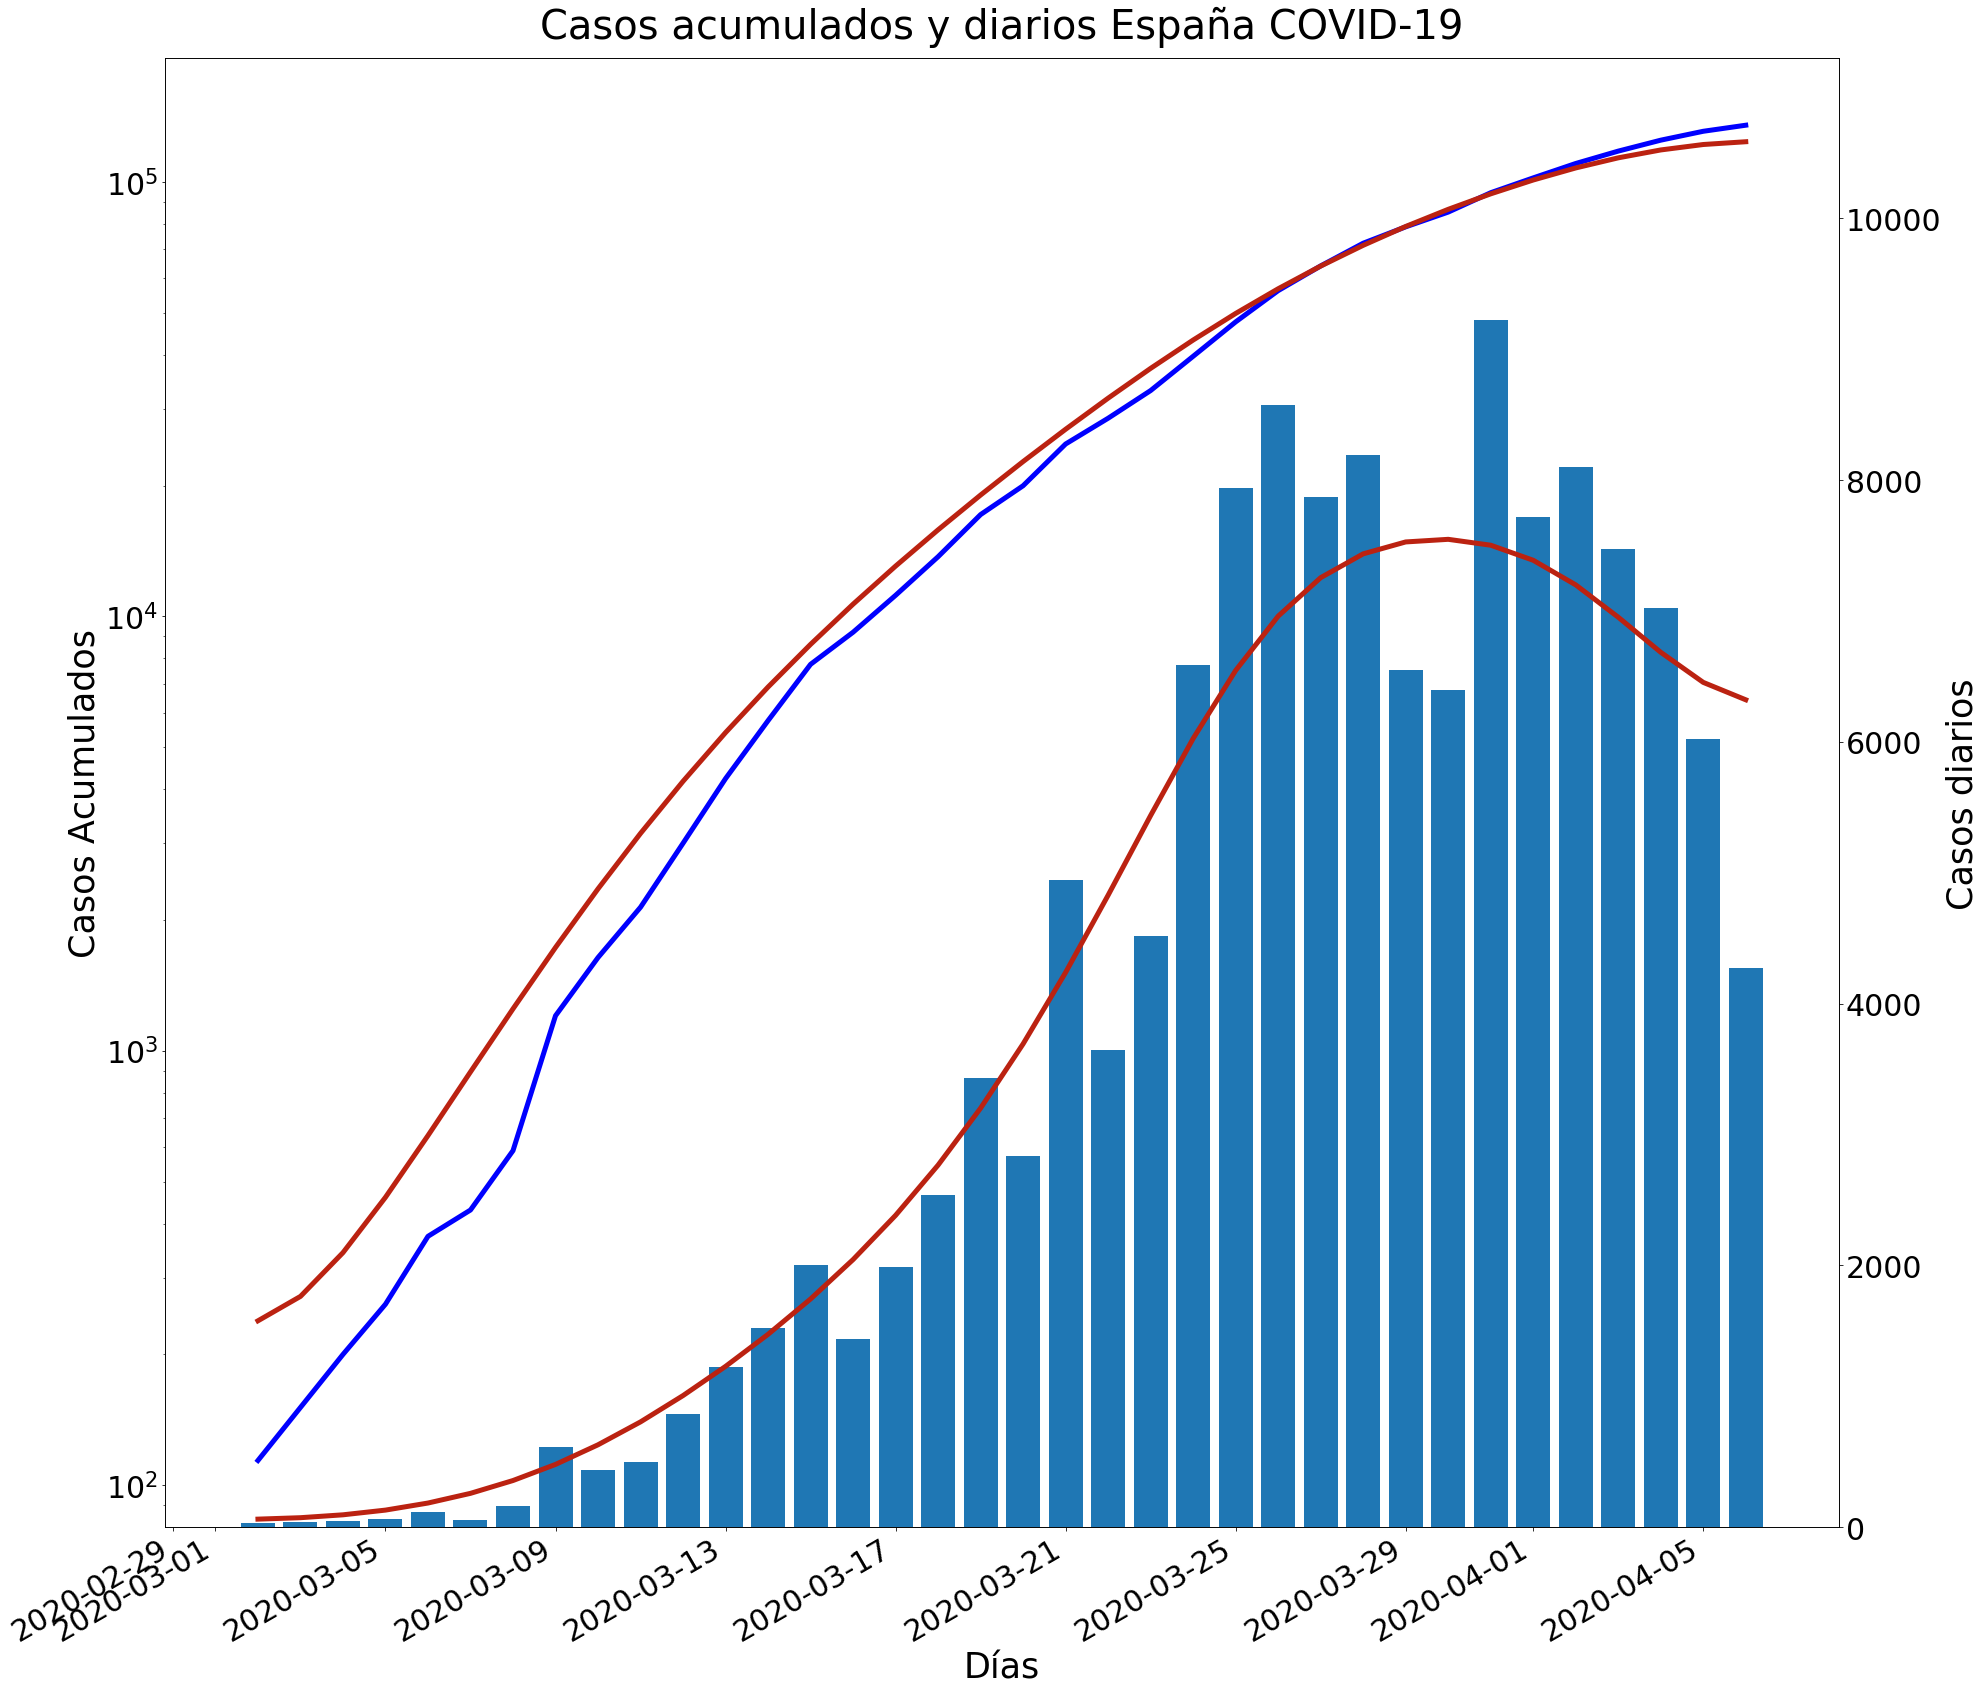

In [126]:
fig, ax1 = plt.subplots(figsize=(30,30))


ax2 = ax1.twinx() 

ax1.plot(ES['dateRep'], ES['casesacum'],linewidth=5, color = 'blue')
ax1.plot(ES['dateRep'], gaussian_filter1d( ES['casesacum'], sigma=3),linewidth=5, color = '#BB2211')
ax1.set_yscale('log')

ax2.bar(ES['dateRep'], ES['cases'])
ax2.plot(ES['dateRep'], gaussian_filter1d( ES['cases'], sigma=3),linewidth=5, color = '#BB2211')


ax1.tick_params(axis='x', labelsize=30)
ax1.tick_params(axis='y', labelsize=30)
ax2.tick_params(axis='y', labelsize=30)

fig.autofmt_xdate()

ax2.set_ylim(0,max(ES['cases'])+2000)

ax1.set_xlabel("Días", fontsize=35)
ax1.set_ylabel("Casos Acumulados", fontsize=35)
ax2.set_ylabel("Casos diarios", fontsize=35)


plt.title("Casos acumulados y diarios España COVID-19", fontsize=40, loc='center', pad=20)
plt.savefig("CasosAcumuladosDiariosES.jpg", bbox_inches = "tight")

plt.show()